<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 3 - RNN

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br>

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br>


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

For some time around 2016–2017, bidirectional RNNs (in particular, `bidirectional LSTMs`) were considered to be the state of the art for sequence modeling. However, nowadays sequence modeling is almost universally done with `Transformers`.

F. Chollet: "One-dimensional convnets were never very popular in NLP, even though, a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost."

### Import Packages

In [1]:
from packaging import version
import pandas as pd
import numpy as np
import datetime
import re
import matplotlib.pyplot as plt
import string

import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
import tensorflow.keras.backend as k
from tensorflow.keras import models, layers, callbacks

import nltk
from nltk.corpus import stopwords
import time

\### Verify TensorFlow version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.15.0


### Stopword Function

In [2]:
nltk.download('stopwords',quiet=True)
STOPWORDS = set(stopwords.words("english"))
custom_articles = {"the", "a", "an"}
STOPWORDS.update(custom_articles)

In [3]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

### Plotting Model Performance Metrics

In [4]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Mount Google Drive to Colab environment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Load Data

In [5]:
!tfds build --register_checksums --datasets=ag_news_subset

INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.datasets.ag_news_subset.ag_news_subset_dataset_builder
2024-05-03 22:09:17.604506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 22:09:17.604579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 22:09:17.606367: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 22:09:21.102068: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO[utils.py]: NumExpr defaulting to 2 threads.
2024-05-03 22:09:24.517557: W external/local_tsl/tsl/pla

In [6]:
dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

### Preparing Integer Sequence Datasets

In [7]:
max_length = 30
max_tokens = 3000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [ ]:
# Check one sample from the training dataset
for text_batch, label_batch in int_train_ds.take(1):
    print("Text batch shape: ", text_batch.shape)
    print("Label batch shape: ", label_batch.shape)
    print("Text batch: ", text_batch.numpy()[:1])  # Display the first text entry in the batch


Text batch shape:  (32, 30)
Label batch shape:  (32,)
Text batch:  [[1575    2    4    1    1  600  647    1  579 1573  852  170    1  160
   150  231    1    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


### Bi-directional RNN

When translating in real-time, it would help to have access to worlds towards the end of a sentence, say, as well as earlier words in the sentence. One way to use the later words in the sentence is to feed the words into our RNN backward. So if we create two independent RNNs, we can feed one the words in their forward, or natural order, and the second gets their words in the revser order. This is the idea behind `Bi-directional RNNS`:

<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/BidirectionalRNN.png?raw=1">

### Understanding word embeddings

When you encode something via `one-hot encoding`, you’re making a feature-engineering decision. You’re injecting into your model a fundamental assumption about the structure of your feature space. That assumption is that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another.

However, in a reasonable word vector space, you would expect synonyms to be embedded into similar word vectors, and in general, you would expect the geometric distance  between any two word vectors to relate to the “semantic distance” between the associated words.

Words that mean different things should lie far away from each other, whereas related words should be closer.

`Word embeddings` are vector representations of words that achieve exactly this: they map human language into a structured geometric space.

Whereas the vectors obtained through `one-hot encoding` are *binary*, *sparse*, and *very high-dimensional* (the same dimensionality as the number of words in the vocabulary), `word embeddings` are *low-dimensional floating-point vectors* (that is, `dense vectors`, as opposed to `sparse vectors`).

<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/EmbeddingsSparse.png?raw=1">

### Two ways to obtain word embeddings

1. `Learn word embeddings jointly with the main task you care about` (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
2. Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called `pretrained word embeddings`.


<div class="alert alert-block alert-success"><b>tf.keras.layers.Embedding</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding </div>

### Understanding Padding and Masking

One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_ length` option in TextVectorization (with `max_length equal` to 150): sentences longer than 150 tokens are truncated to a length of 150 tokens, and sentences shorter than 150 tokens are padded with zeros at the end so that they can be concatenated together with other sequences to form contiguous batches.

The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an API for that: `masking`.

<div class="alert alert-block alert-success"><b>tf.keras.layers.Masking</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking</div>

#SIMPLE RNN

In [ ]:
max_tokens = 3000 + 1
max_length = 30

model_1 = models.Sequential([
    layers.Input(shape=(max_length,), dtype='int64', name='input'),
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_length),
    layers.SimpleRNN(units=64),
    layers.Dense(4, activation='softmax')
])

In [ ]:
model_1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 128)           384128    
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 396740 (1.51 MB)
Trainable params: 396740 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_callbacks = [
    callbacks.ModelCheckpoint("SimpleRNN.h5", save_best_only=True),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
]

In [ ]:
# Capture the time and train
start_time = time.time()
history_1 = model_1.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=model_callbacks
)
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")


Epoch 1/10
3563/3563 [==============================] - 128s 35ms/step - loss: 0.4787 - accuracy: 0.8340 - val_loss: 0.3868 - val_accuracy: 0.8725


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
3563/3563 [==============================] - 114s 32ms/step - loss: 0.3650 - accuracy: 0.8780 - val_loss: 0.4039 - val_accuracy: 0.8660
Epoch 3/10
3563/3563 [==============================] - 111s 31ms/step - loss: 0.3280 - accuracy: 0.8899 - val_loss: 0.4422 - val_accuracy: 0.8623
Epoch 4/10
3563/3563 [==============================] - 120s 34ms/step - loss: 0.3006 - accuracy: 0.8987 - val_loss: 0.4396 - val_accuracy: 0.8672
Epoch 4: early stopping
Total training time: 488.63 seconds


In [ ]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_1.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_1.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_1.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")


Training Accuracy: 0.9037
Training Loss: 0.3019
Validation Accuracy: 0.8672
Validation Loss: 0.4396
238/238 [==============================] - 2s 6ms/step - loss: 0.4251 - accuracy: 0.8693
Test Accuracy: 0.8693
Test Loss: 0.4251


<ipython-input-5-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


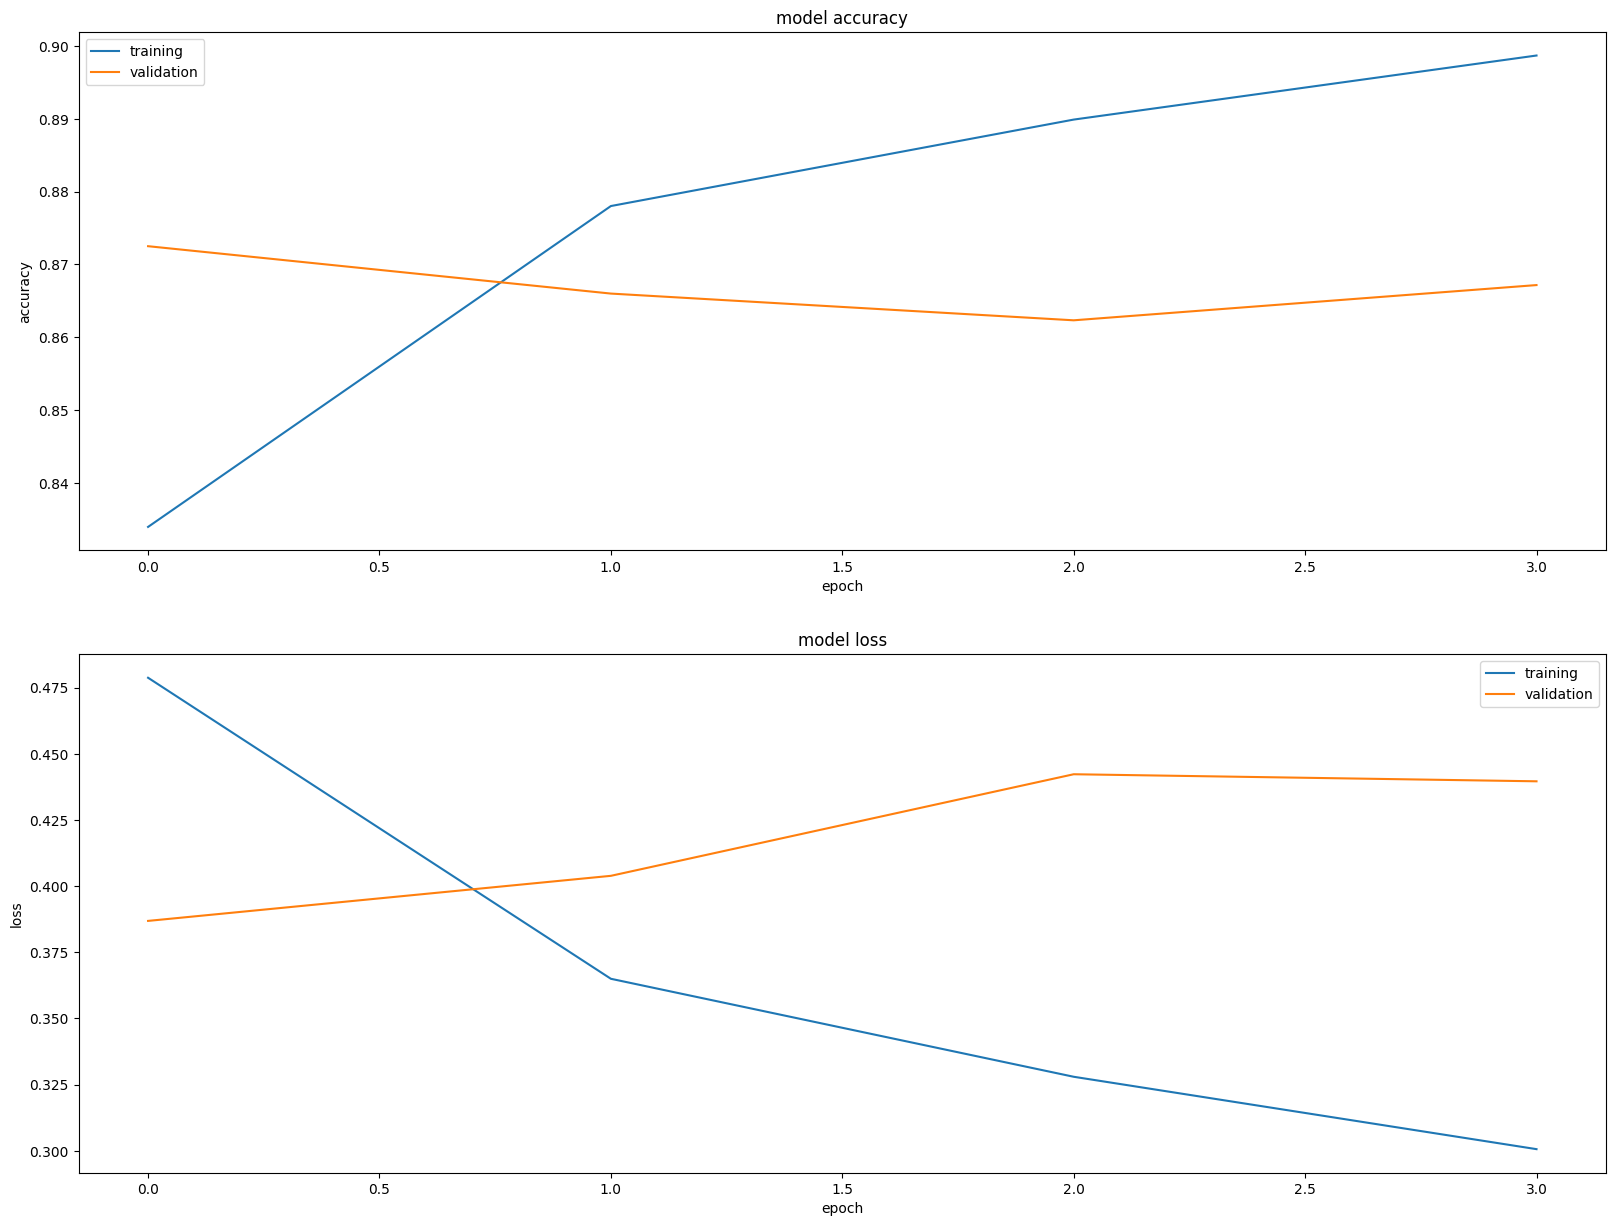

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_1.history['accuracy'], history_1.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_1.history['loss'], history_1.history['val_loss'], 'loss', 212)

In [ ]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_1.predict(int_test_ds), axis=-1)

238/238 [==============================] - 1s 5ms/step


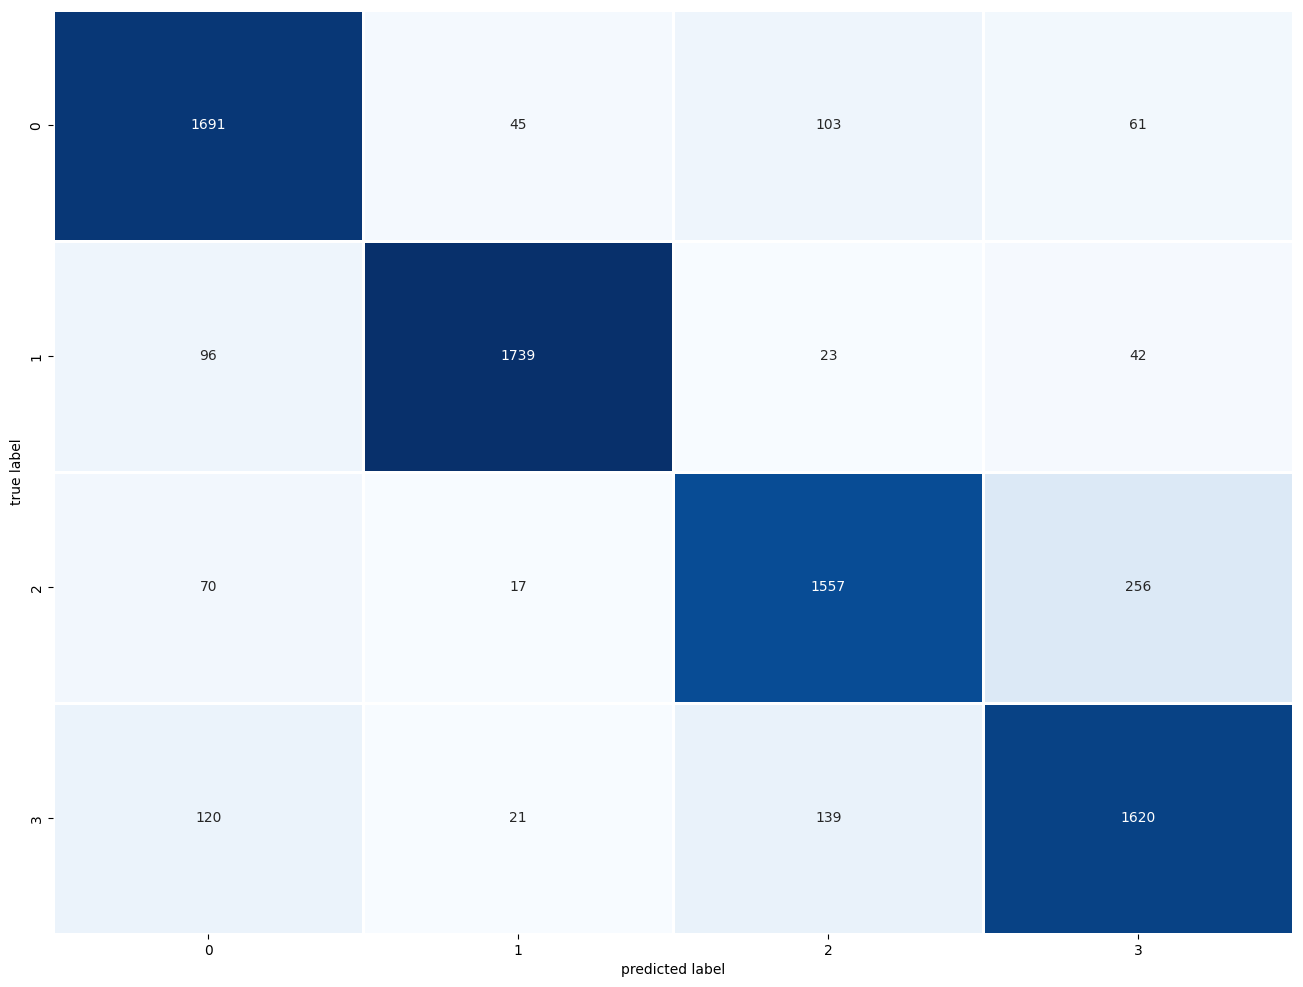

In [ ]:
plot_confusion_matrix(y_test,pred_classes)

# Bi-directional RNN 1 layer


In [10]:
k.clear_session()
max_tokens = 3000 + 1
max_length = 30

model_2 = models.Sequential([
    layers.Input(shape=(None, ), dtype='int64'),
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_length),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(4, activation='softmax', name='outer')
])


In [11]:
model_2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         384128    
                                                                 
 bidirectional (Bidirection  (None, 128)               24704     
 al)                                                             
                                                                 
 outer (Dense)               (None, 4)                 516       
                                                                 
Total params: 409348 (1.56 MB)
Trainable params: 409348 (1.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model_callbacks = [
    callbacks.ModelCheckpoint("SimpleRNN.h5", save_best_only=True),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
]

In [14]:
# Capture the time and train
start_time = time.time()
history_2 = model_2.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=model_callbacks
)
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 101s 27ms/step - loss: 0.4190 - accuracy: 0.8504 - val_loss: 0.3725 - val_accuracy: 0.8715
Epoch 2/10
   1/3563 [..............................] - ETA: 2:13 - loss: 0.4334 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 93s 26ms/step - loss: 0.3160 - accuracy: 0.8901 - val_loss: 0.3825 - val_accuracy: 0.8645
Epoch 3/10
3563/3563 [==============================] - 93s 26ms/step - loss: 0.2601 - accuracy: 0.9094 - val_loss: 0.4174 - val_accuracy: 0.8598
Epoch 4/10
3563/3563 [==============================] - 102s 29ms/step - loss: 0.2135 - accuracy: 0.9258 - val_loss: 0.4572 - val_accuracy: 0.8552
Epoch 4: early stopping
Total training time: 389.00 seconds


In [15]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_2.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_2.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_2.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9270
Training Loss: 0.2044
Validation Accuracy: 0.8552
Validation Loss: 0.4572
238/238 [==============================] - 3s 12ms/step - loss: 0.4475 - accuracy: 0.8611
Test Accuracy: 0.8611
Test Loss: 0.4475


<ipython-input-6-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


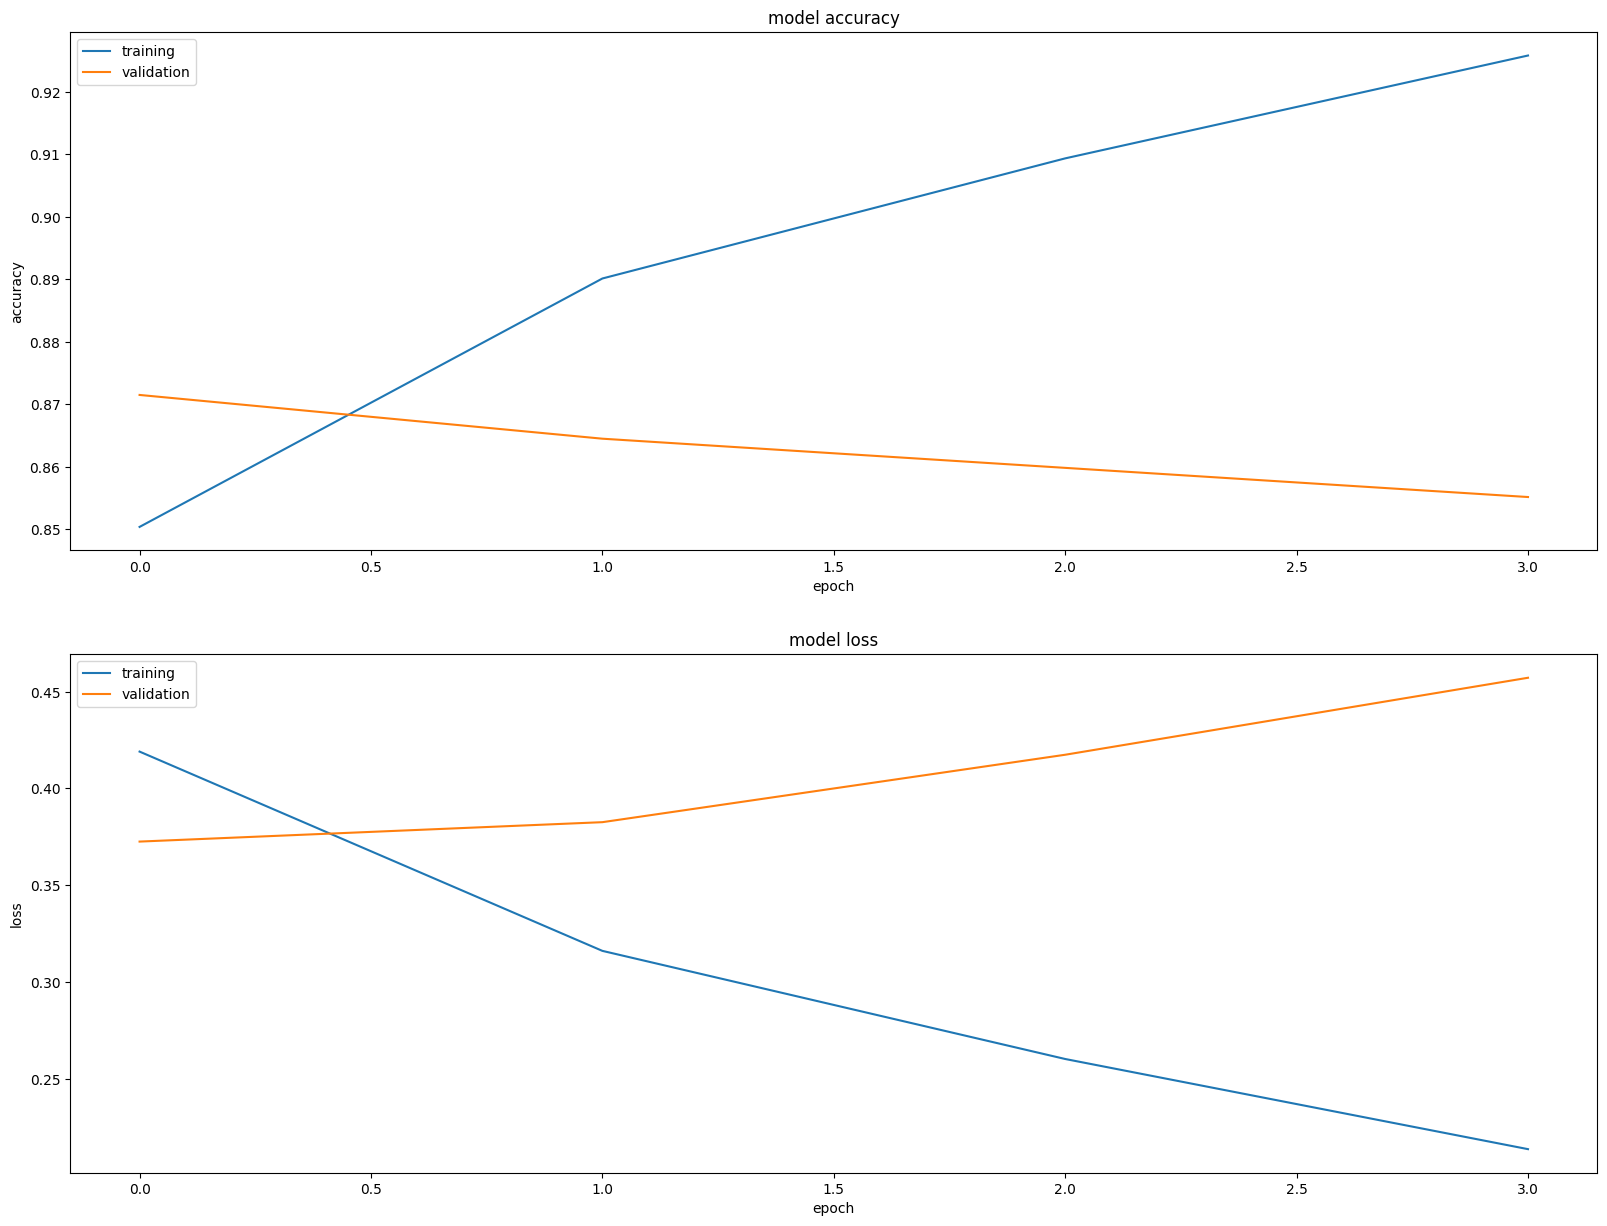

In [16]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_2.history['accuracy'], history_2.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_2.history['loss'], history_2.history['val_loss'], 'loss', 212)

238/238 [==============================] - 2s 6ms/step


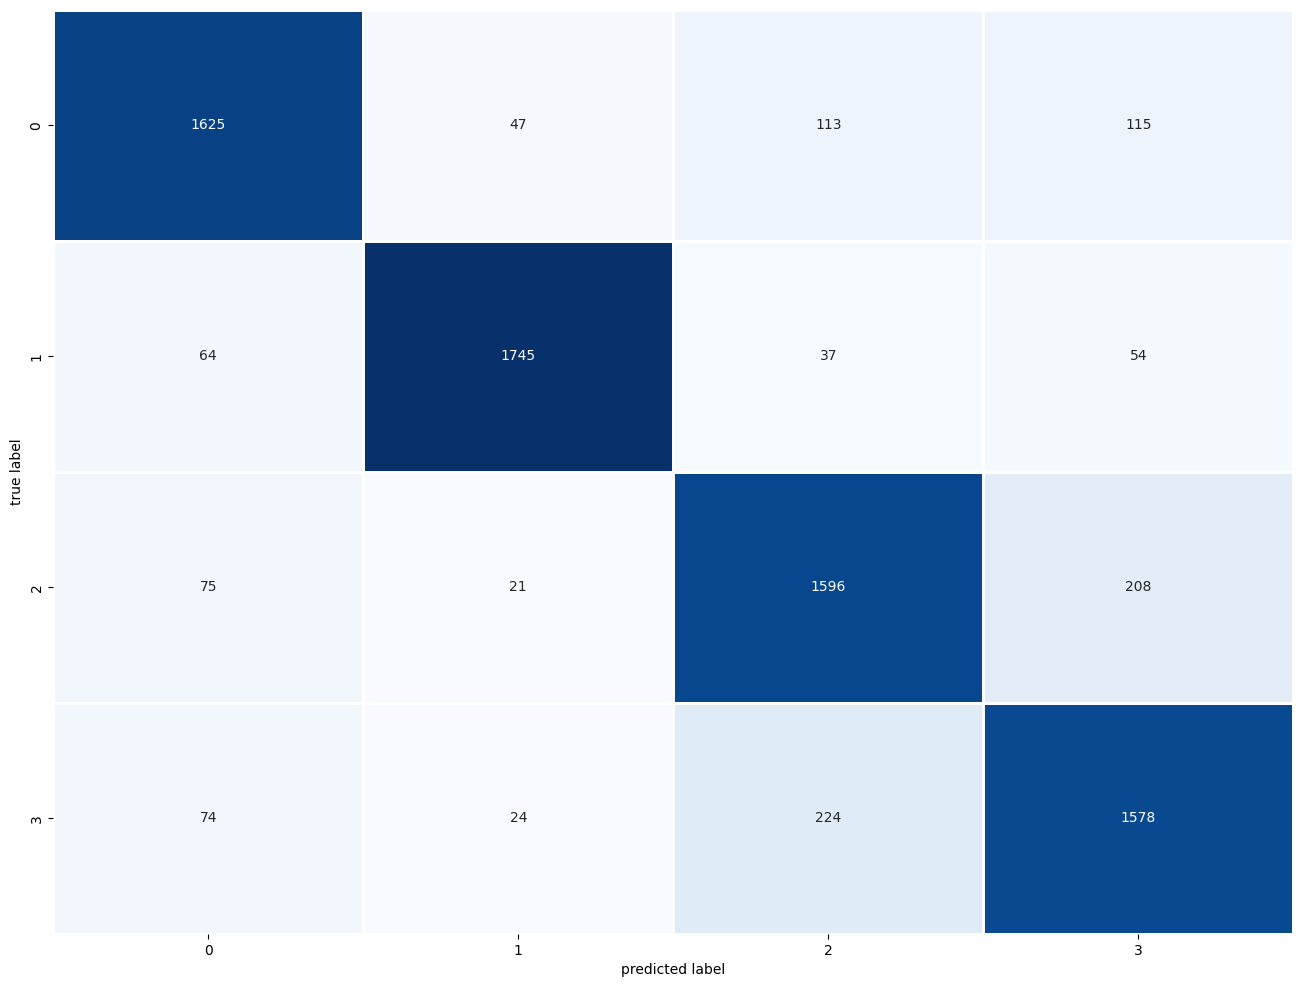

In [17]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_2.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

# Bi-directional RNN 2 layers

In [18]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

model_3 = models.Sequential([
    layers.Input(shape=(None, ), dtype='int64'),
    layers.Embedding(input_dim=max_tokens, output_dim=128, input_length=max_length),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences=True)),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Dense(4, activation='softmax', name='outer')
])

In [19]:
model_3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [20]:
model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         384128    
                                                                 
 bidirectional (Bidirection  (None, None, 128)         24704     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               24704     
 onal)                                                           
                                                                 
 outer (Dense)               (None, 4)                 516       
                                                                 
Total params: 434052 (1.66 MB)
Trainable params: 434052 (1.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
model_callbacks = [
    callbacks.ModelCheckpoint("SimpleRNN.h5", save_best_only=True),
    callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
]

In [22]:
# Capture the time and train
start_time = time.time()
history_3 = model_3.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=model_callbacks
)
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 166s 45ms/step - loss: 0.4326 - accuracy: 0.8452 - val_loss: 0.3796 - val_accuracy: 0.8673
Epoch 2/10
   1/3563 [..............................] - ETA: 2:34 - loss: 0.3626 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 159s 45ms/step - loss: 0.3315 - accuracy: 0.8849 - val_loss: 0.3581 - val_accuracy: 0.8768
Epoch 3/10
3563/3563 [==============================] - 161s 45ms/step - loss: 0.2856 - accuracy: 0.9004 - val_loss: 0.3965 - val_accuracy: 0.8657
Epoch 4/10
3563/3563 [==============================] - 160s 45ms/step - loss: 0.2415 - accuracy: 0.9153 - val_loss: 0.3997 - val_accuracy: 0.8735
Epoch 5/10
3563/3563 [==============================] - 170s 48ms/step - loss: 0.2079 - accuracy: 0.9278 - val_loss: 0.4245 - val_accuracy: 0.8722
Epoch 5: early stopping
Total training time: 857.05 seconds


In [23]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_3.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_3.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_3.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9252
Training Loss: 0.2164
Validation Accuracy: 0.8722
Validation Loss: 0.4245
238/238 [==============================] - 3s 10ms/step - loss: 0.4261 - accuracy: 0.8725
Test Accuracy: 0.8725
Test Loss: 0.4261


<ipython-input-6-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


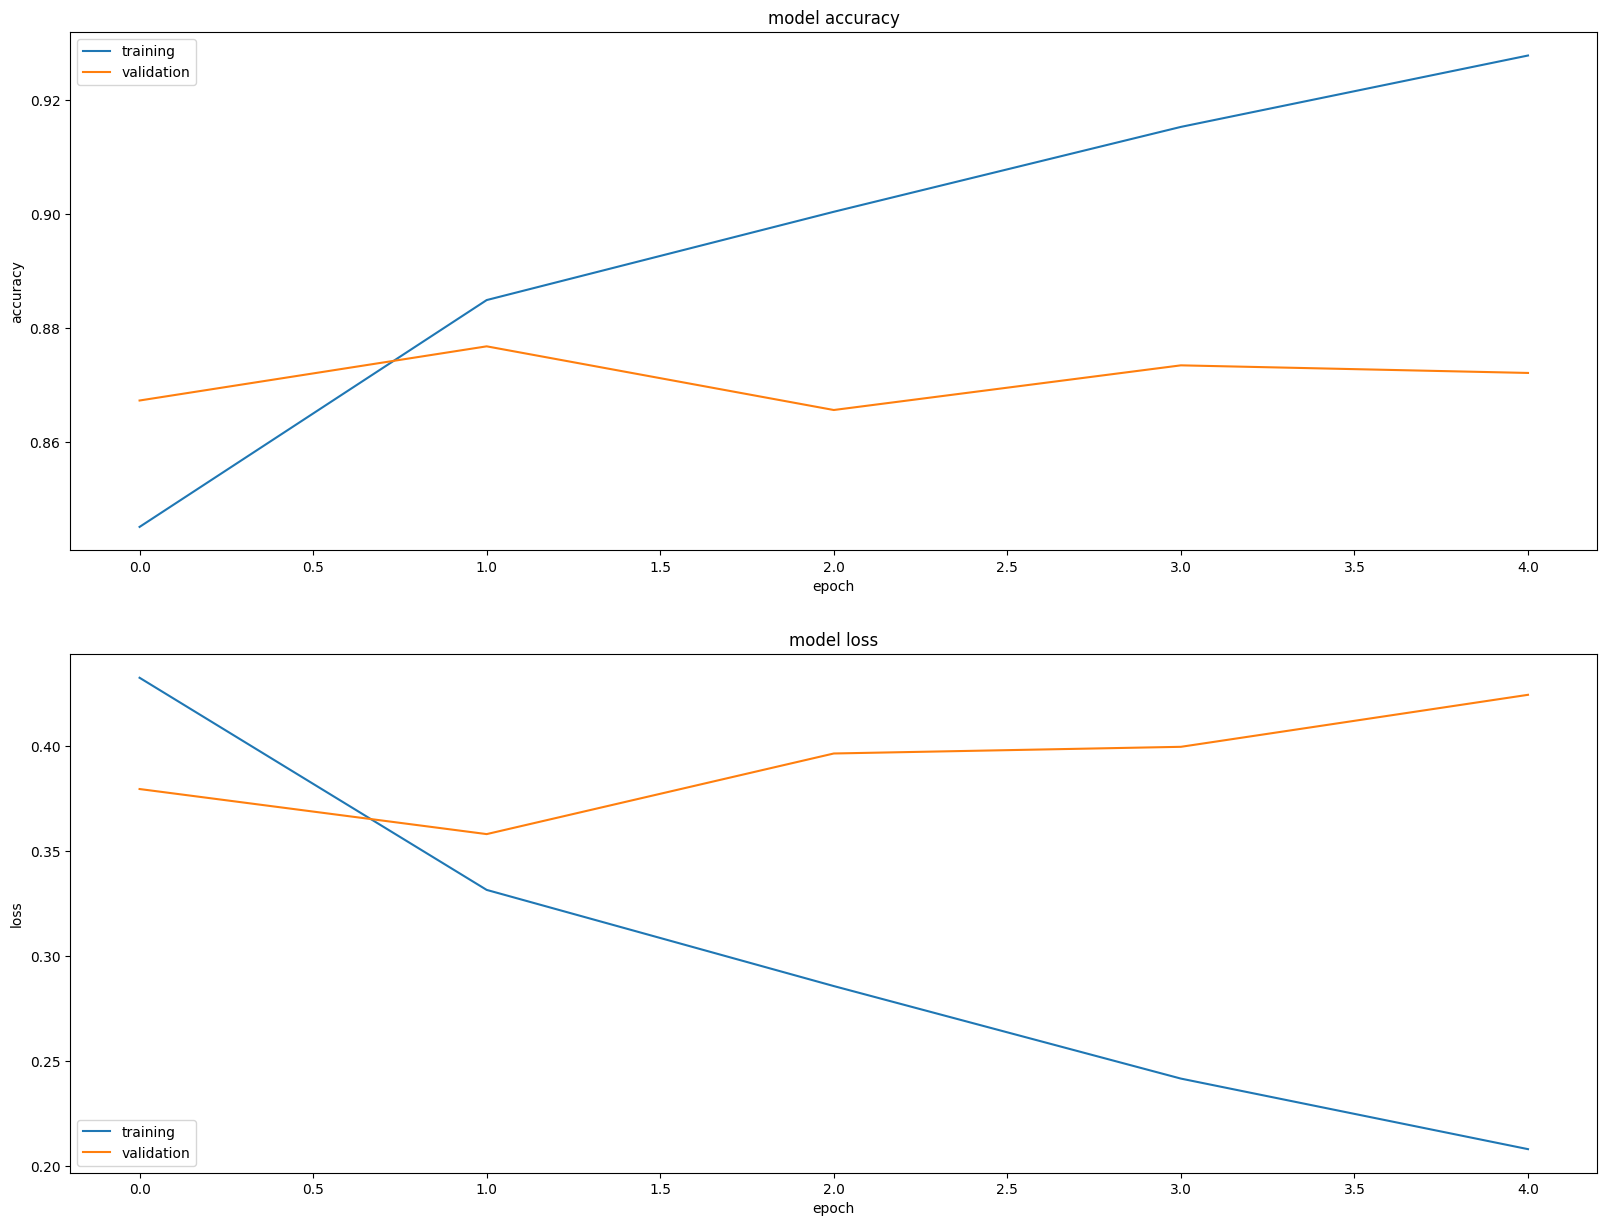

In [24]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_3.history['accuracy'], history_3.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_3.history['loss'], history_3.history['val_loss'], 'loss', 212)

238/238 [==============================] - 4s 12ms/step


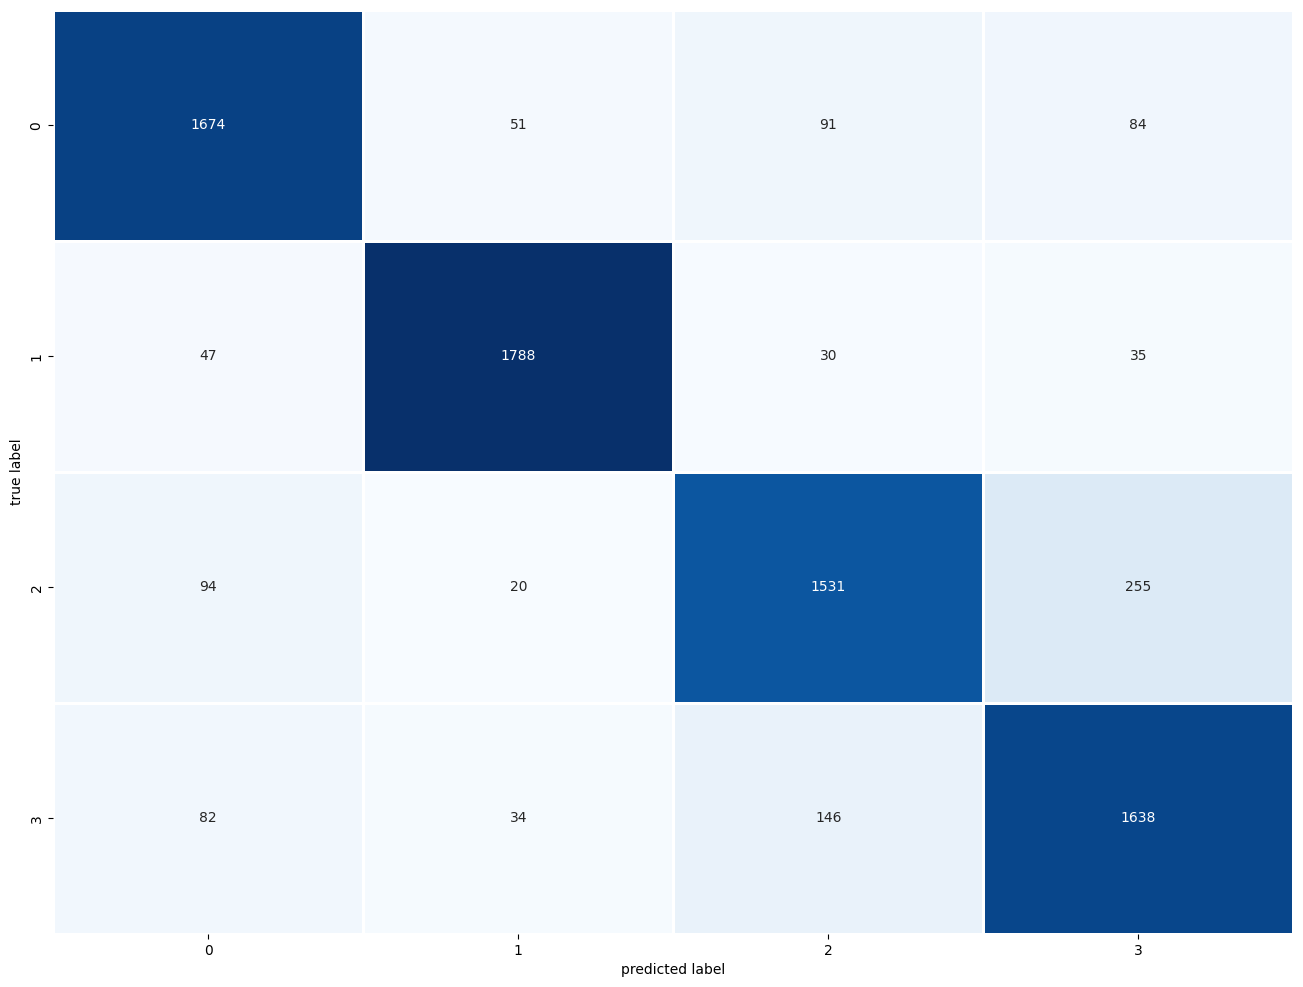

In [25]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_3.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

#LSTM model _ 1 Layer

In [10]:
k.clear_session()
max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(max_length,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.LSTM(32)(embedded)
outputs = layers.Dense(4, activation="softmax")(x)

model_4 = tf.keras.Model(inputs=inputs, outputs=outputs)


In [11]:
model_4.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           768256    
                                                                 
 lstm (LSTM)                 (None, 32)                36992     
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 805380 (3.07 MB)
Trainable params: 805380 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [14]:
# Train the model
start_time = time.time()
history_4 = model_4.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_4 = keras.models.load_model("LSTM.h5")
end_time = time.time()

# Calculate the total training time
total_training_time_4 = end_time - start_time
print(f"Total training time for model_4: {total_training_time_4:.2f} seconds")


Epoch 1/10
3563/3563 [==============================] - 140s 37ms/step - loss: 0.3977 - accuracy: 0.8610 - val_loss: 0.3349 - val_accuracy: 0.8858


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
3563/3563 [==============================] - 134s 38ms/step - loss: 0.3124 - accuracy: 0.8933 - val_loss: 0.3252 - val_accuracy: 0.8873
Epoch 3/10
3563/3563 [==============================] - 128s 36ms/step - loss: 0.2873 - accuracy: 0.9018 - val_loss: 0.3223 - val_accuracy: 0.8907
Epoch 4/10
3563/3563 [==============================] - 149s 42ms/step - loss: 0.2680 - accuracy: 0.9079 - val_loss: 0.3223 - val_accuracy: 0.8892
Epoch 5/10
3563/3563 [==============================] - 134s 38ms/step - loss: 0.2513 - accuracy: 0.9145 - val_loss: 0.3331 - val_accuracy: 0.8903
Epoch 6/10
3563/3563 [==============================] - 123s 34ms/step - loss: 0.2356 - accuracy: 0.9202 - val_loss: 0.3400 - val_accuracy: 0.8902
Total training time for model_4: 865.36 seconds


In [15]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_4.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy for model_4: {train_accuracy:.4f}")
print(f"Training Loss for model_4: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_4.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy for model_4: {val_accuracy:.4f}")
print(f"Validation Loss for model_4: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_4.evaluate(int_test_ds)
print(f"Test Accuracy for model_4: {accuracy:.4f}")
print(f"Test Loss for model_4: {loss:.4f}")


Training Accuracy for model_4: 0.9171
Training Loss for model_4: 0.2426
Validation Accuracy for model_4: 0.8892
Validation Loss for model_4: 0.3223
238/238 [==============================] - 4s 14ms/step - loss: 0.3285 - accuracy: 0.8904
Test Accuracy for model_4: 0.8904
Test Loss for model_4: 0.3285


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


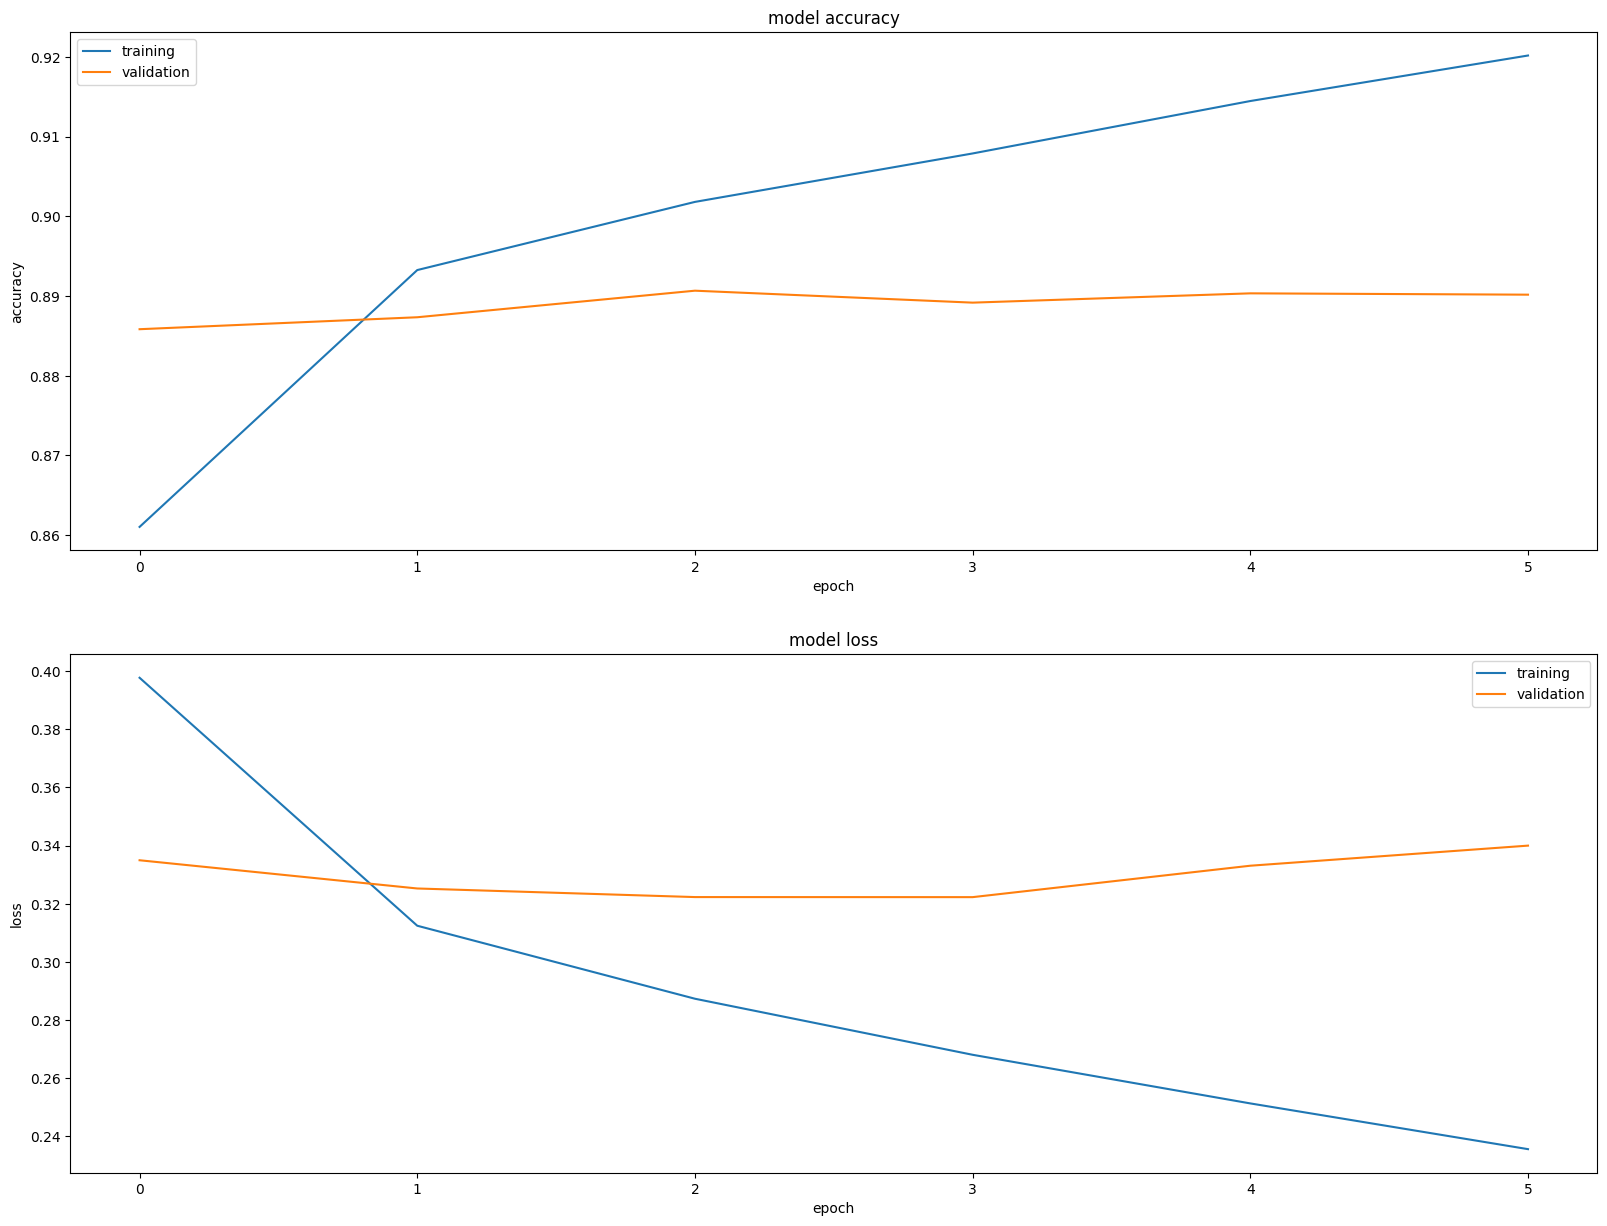

In [16]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_4.history['accuracy'], history_4.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_4.history['loss'], history_4.history['val_loss'], 'loss', 212)

238/238 [==============================] - 4s 8ms/step


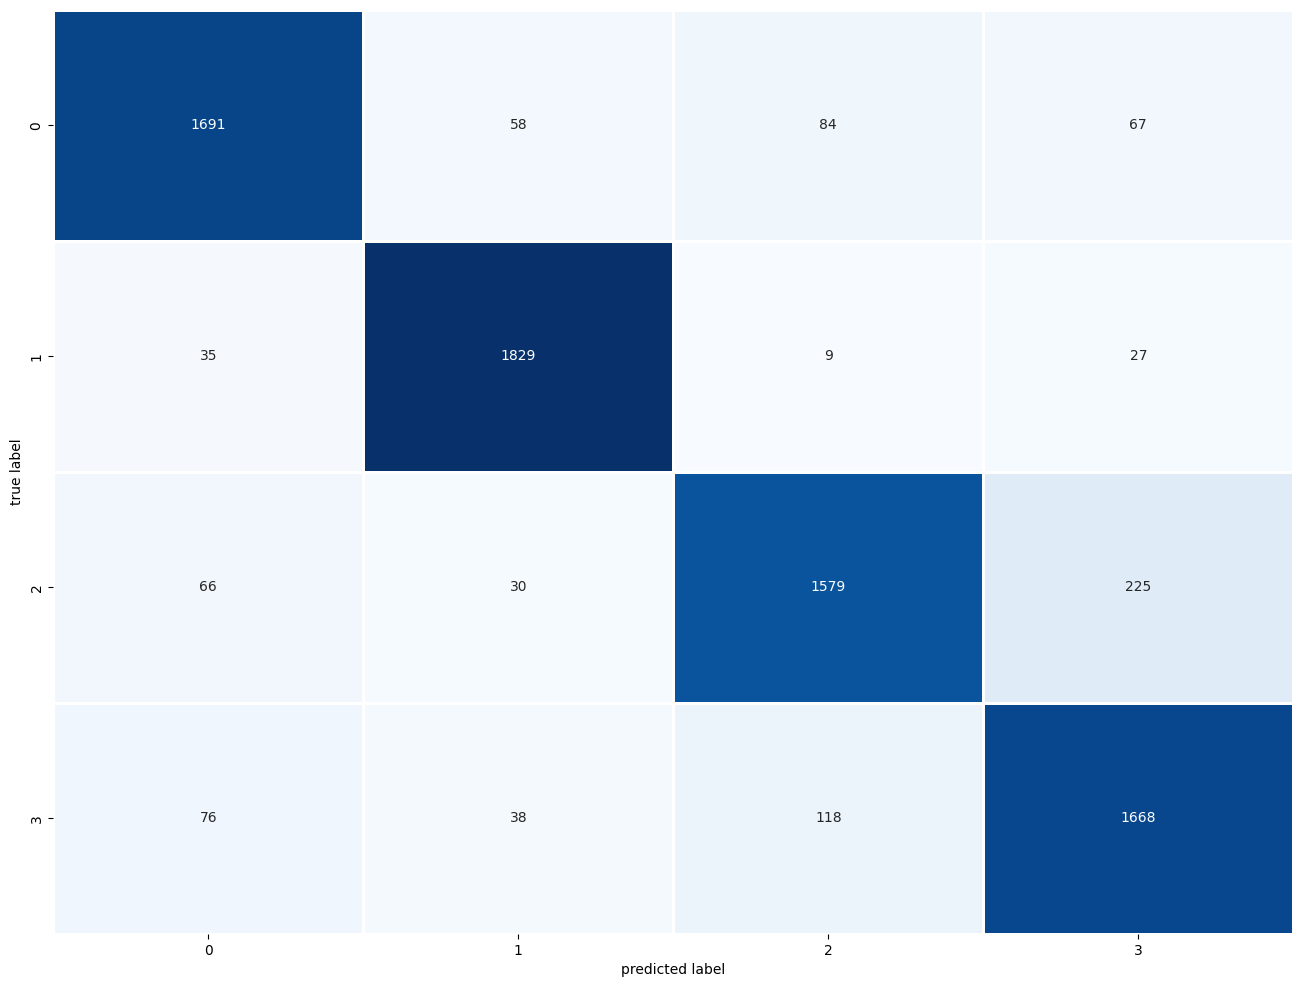

In [17]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_4.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

# LSTM bi-directional

In [18]:
k.clear_session()
max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(max_length,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
outputs = layers.Dense(4, activation="softmax")(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs)


In [27]:
model_5.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           768256    
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 842500 (3.21 MB)
Trainable params: 842500 (3.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [22]:
# Train the model
start_time = time.time()
history_5 = model_5.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_5 = keras.models.load_model("LSTM.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time for model_5: {total_training_time:.2f} seconds")


Epoch 1/10
3563/3563 [==============================] - 279s 75ms/step - loss: 0.3656 - accuracy: 0.8706 - val_loss: 0.3128 - val_accuracy: 0.8915
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 264s 74ms/step - loss: 0.2780 - accuracy: 0.9008 - val_loss: 0.3035 - val_accuracy: 0.8952
Epoch 3/10
3563/3563 [==============================] - 224s 63ms/step - loss: 0.2295 - accuracy: 0.9179 - val_loss: 0.3187 - val_accuracy: 0.8950
Epoch 4/10
3563/3563 [==============================] - 224s 63ms/step - loss: 0.1857 - accuracy: 0.9343 - val_loss: 0.3541 - val_accuracy: 0.8867
Epoch 5/10
3563/3563 [==============================] - 249s 70ms/step - loss: 0.1475 - accuracy: 0.9481 - val_loss: 0.3960 - val_accuracy: 0.8835
Total training time for model_5: 1293.18 seconds


In [23]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_5.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_5.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_5.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9228
Training Loss: 0.2171
Validation Accuracy: 0.8952
Validation Loss: 0.3035
238/238 [==============================] - 4s 17ms/step - loss: 0.3108 - accuracy: 0.8941
Test Accuracy: 0.8941
Test Loss: 0.3108


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


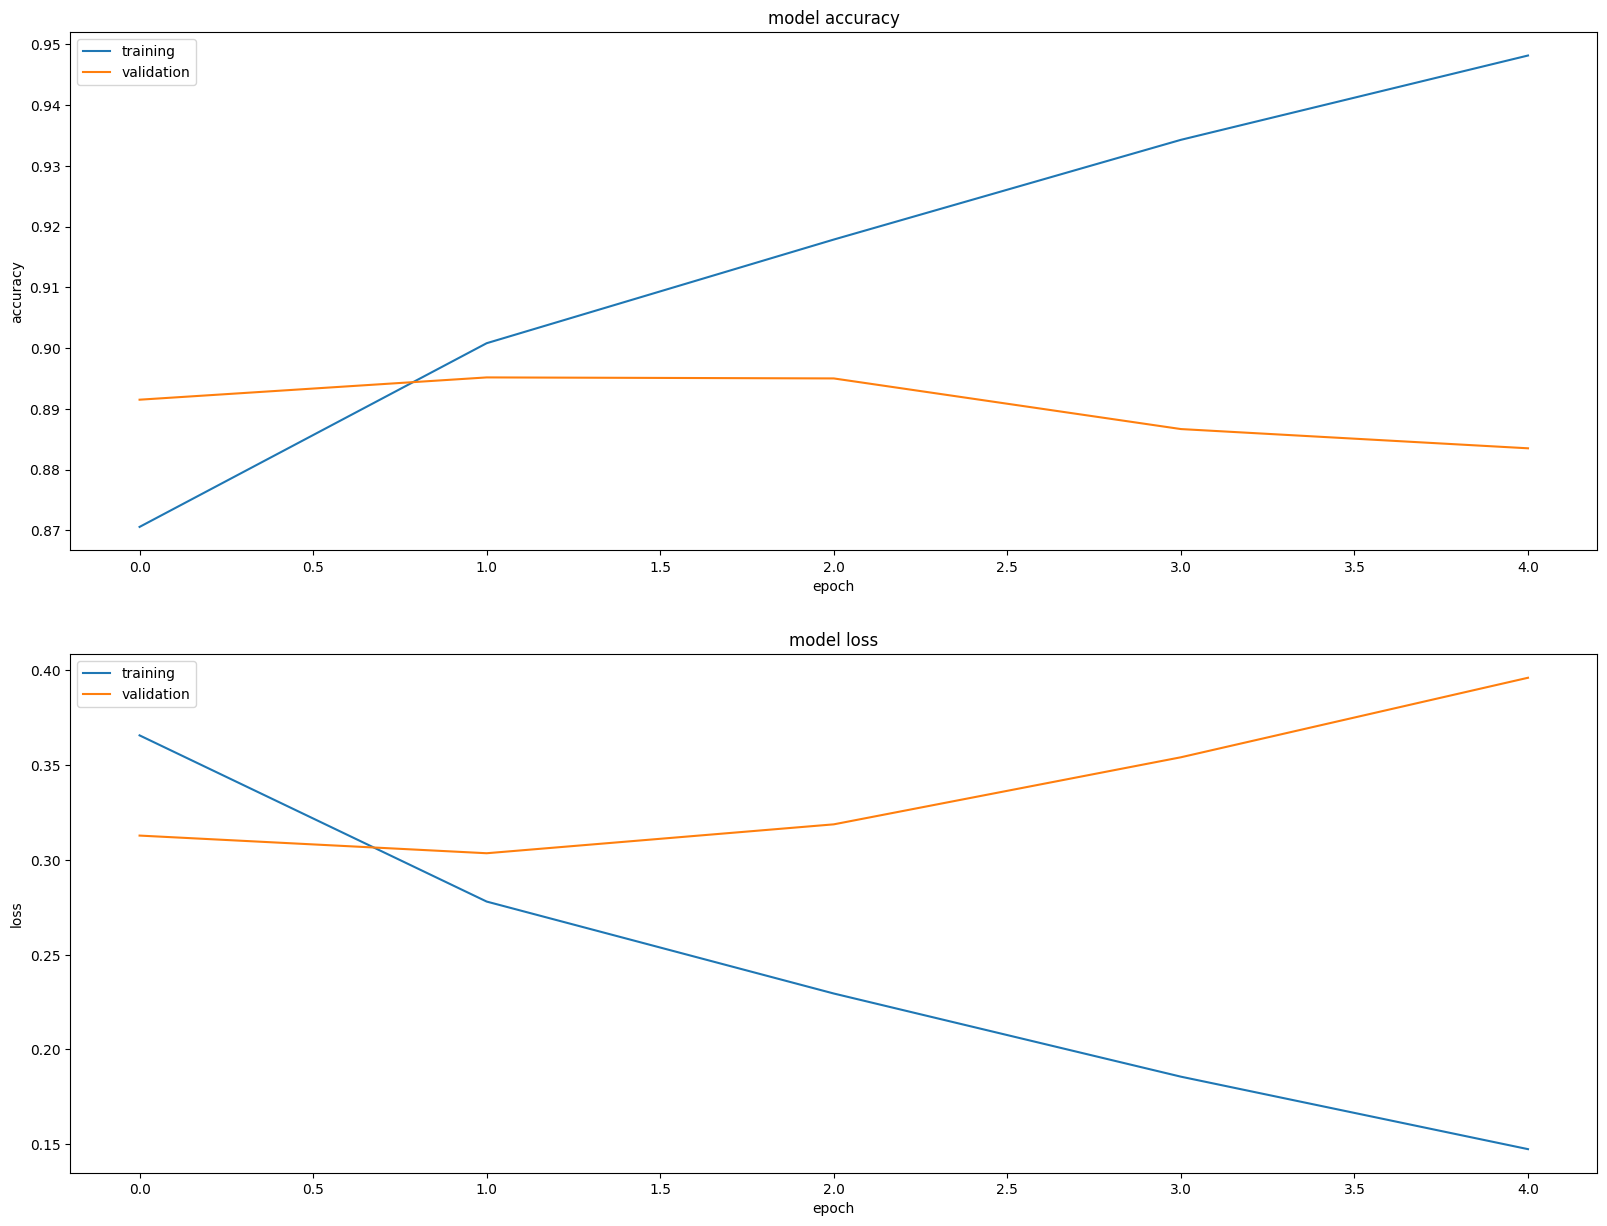

In [24]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_5.history['accuracy'], history_5.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_5.history['loss'], history_5.history['val_loss'], 'loss', 212)

238/238 [==============================] - 3s 13ms/step


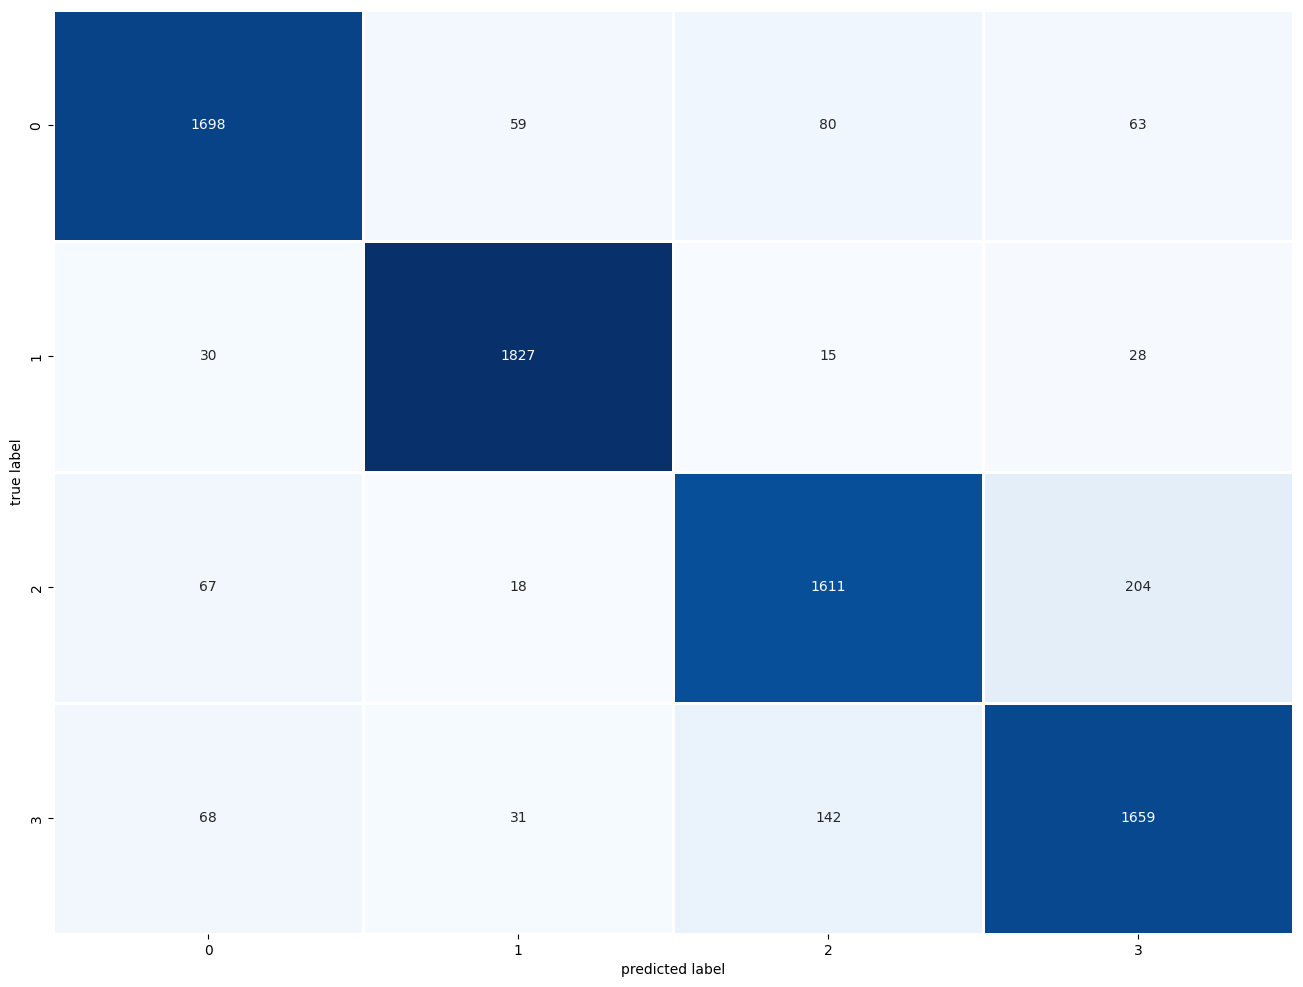

In [26]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_5.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

# LSTM bi-directional with Dropout

In [28]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(max_length,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model_6 = tf.keras.Model(inputs=inputs, outputs=outputs)


In [29]:
model_6.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           768256    
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 842500 (3.21 MB)
Trainable params: 842500 (3.21 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________

In [30]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [31]:
# Train the model
start_time = time.time()
history_6 = model_6.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_6 = keras.models.load_model("LSTM.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 278s 75ms/step - loss: 0.3889 - accuracy: 0.8664 - val_loss: 0.3217 - val_accuracy: 0.8878
Epoch 2/10
   1/3563 [..............................] - ETA: 3:28 - loss: 0.4382 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 221s 62ms/step - loss: 0.3050 - accuracy: 0.8939 - val_loss: 0.3077 - val_accuracy: 0.8898
Epoch 3/10
3563/3563 [==============================] - 222s 62ms/step - loss: 0.2640 - accuracy: 0.9070 - val_loss: 0.3201 - val_accuracy: 0.8913
Epoch 4/10
3563/3563 [==============================] - 260s 73ms/step - loss: 0.2295 - accuracy: 0.9189 - val_loss: 0.3377 - val_accuracy: 0.8902
Epoch 5/10
3563/3563 [==============================] - 245s 69ms/step - loss: 0.2034 - accuracy: 0.9271 - val_loss: 0.3518 - val_accuracy: 0.8888
Epoch 6/10
3563/3563 [==============================] - 242s 68ms/step - loss: 0.1812 - accuracy: 0.9347 - val_loss: 0.3803 - val_accuracy: 0.8860
Total training time: 1568.47 seconds


In [32]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_6.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_6.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_6.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9142
Training Loss: 0.2381
Validation Accuracy: 0.8898
Validation Loss: 0.3077
238/238 [==============================] - 4s 17ms/step - loss: 0.3181 - accuracy: 0.8912
Test Accuracy: 0.8912
Test Loss: 0.3181


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


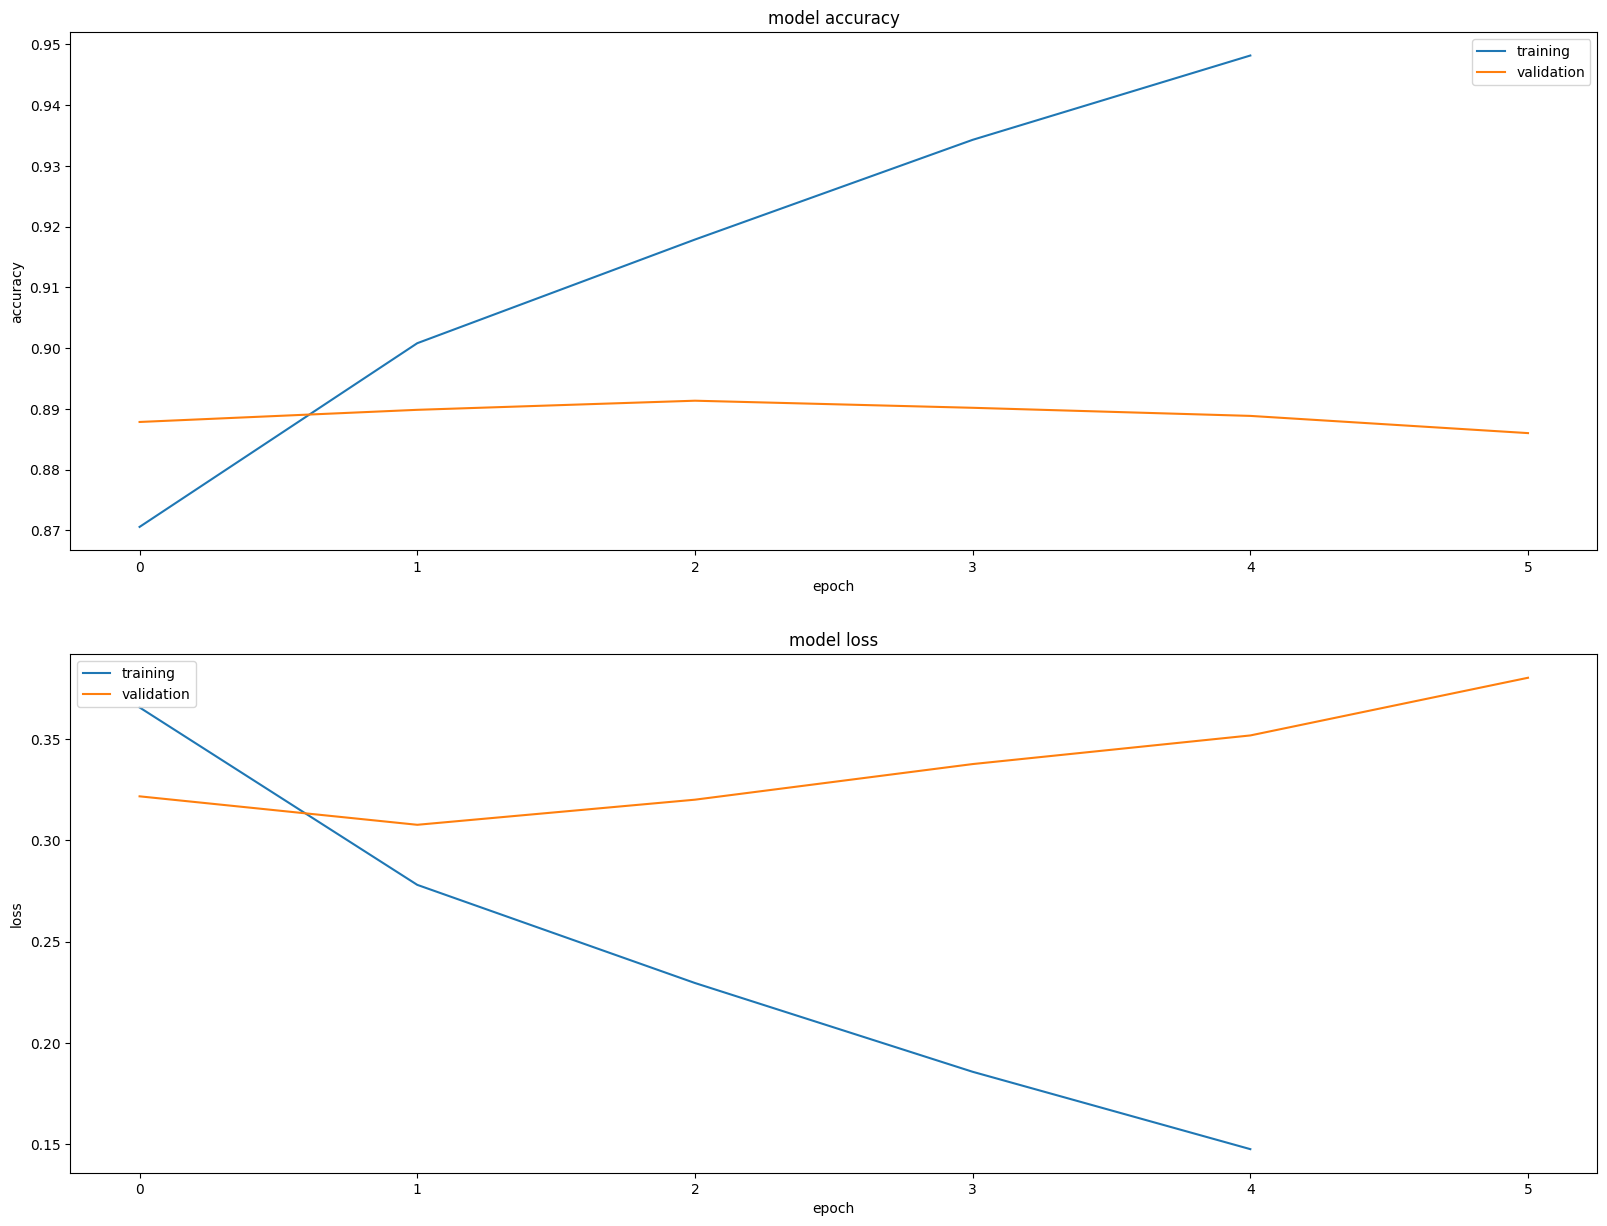

In [33]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_6.history['accuracy'], history_6.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_6.history['loss'], history_6.history['val_loss'], 'loss', 212)

238/238 [==============================] - 6s 13ms/step


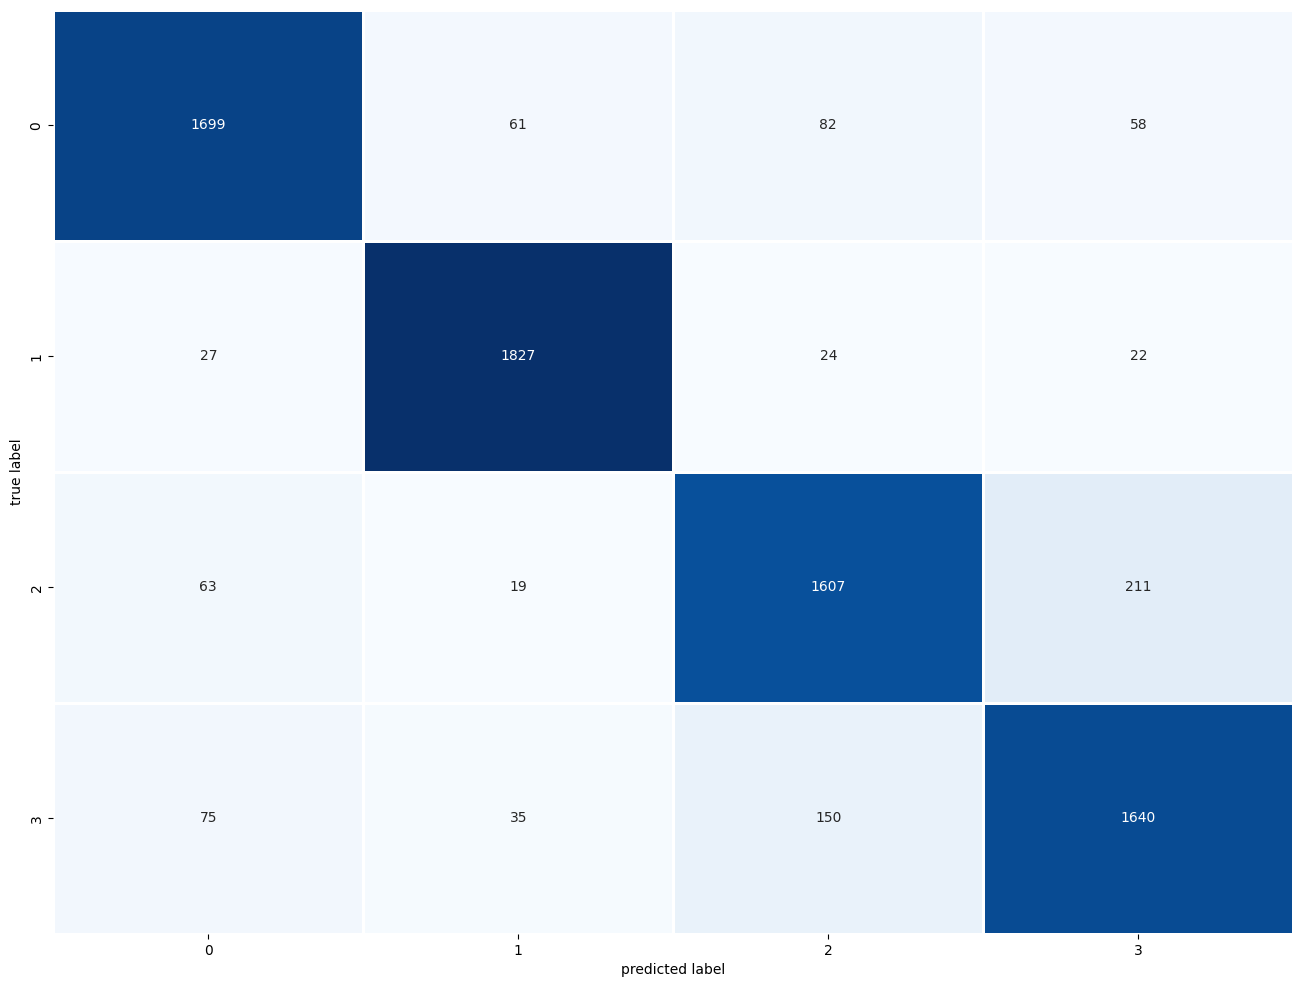

In [34]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_6.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

# LSTM bi-directional with Dropout and L2

In [35]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(max_length,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
outputs = layers.Dense(4, activation="softmax")(x)

model_7 = tf.keras.Model(inputs=inputs, outputs=outputs)


In [36]:
model_7.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           768256    
                                                                 
 bidirectional (Bidirection  (None, 64)                73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 4)                 132       
                                                             

In [37]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [38]:
# Train the model
start_time = time.time()
history_7 = model_7.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_7 = keras.models.load_model("LSTM.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 289s 78ms/step - loss: 0.4126 - accuracy: 0.8628 - val_loss: 0.3387 - val_accuracy: 0.8873
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 230s 64ms/step - loss: 0.3159 - accuracy: 0.8929 - val_loss: 0.3269 - val_accuracy: 0.8878
Epoch 3/10
3563/3563 [==============================] - 225s 63ms/step - loss: 0.2765 - accuracy: 0.9052 - val_loss: 0.3280 - val_accuracy: 0.8907
Epoch 4/10
3563/3563 [==============================] - 226s 64ms/step - loss: 0.2455 - accuracy: 0.9163 - val_loss: 0.3469 - val_accuracy: 0.8860
Epoch 5/10
3563/3563 [==============================] - 251s 70ms/step - loss: 0.2212 - accuracy: 0.9247 - val_loss: 0.3671 - val_accuracy: 0.8858
Epoch 6/10
3563/3563 [==============================] - 225s 63ms/step - loss: 0.2009 - accuracy: 0.9309 - val_loss: 0.3792 - val_accuracy: 0.8830
Total training time: 1520.44 seconds


In [39]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_7.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_7.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_7.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9111
Training Loss: 0.2570
Validation Accuracy: 0.8878
Validation Loss: 0.3269
238/238 [==============================] - 3s 13ms/step - loss: 0.3359 - accuracy: 0.8861
Test Accuracy: 0.8861
Test Loss: 0.3359


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


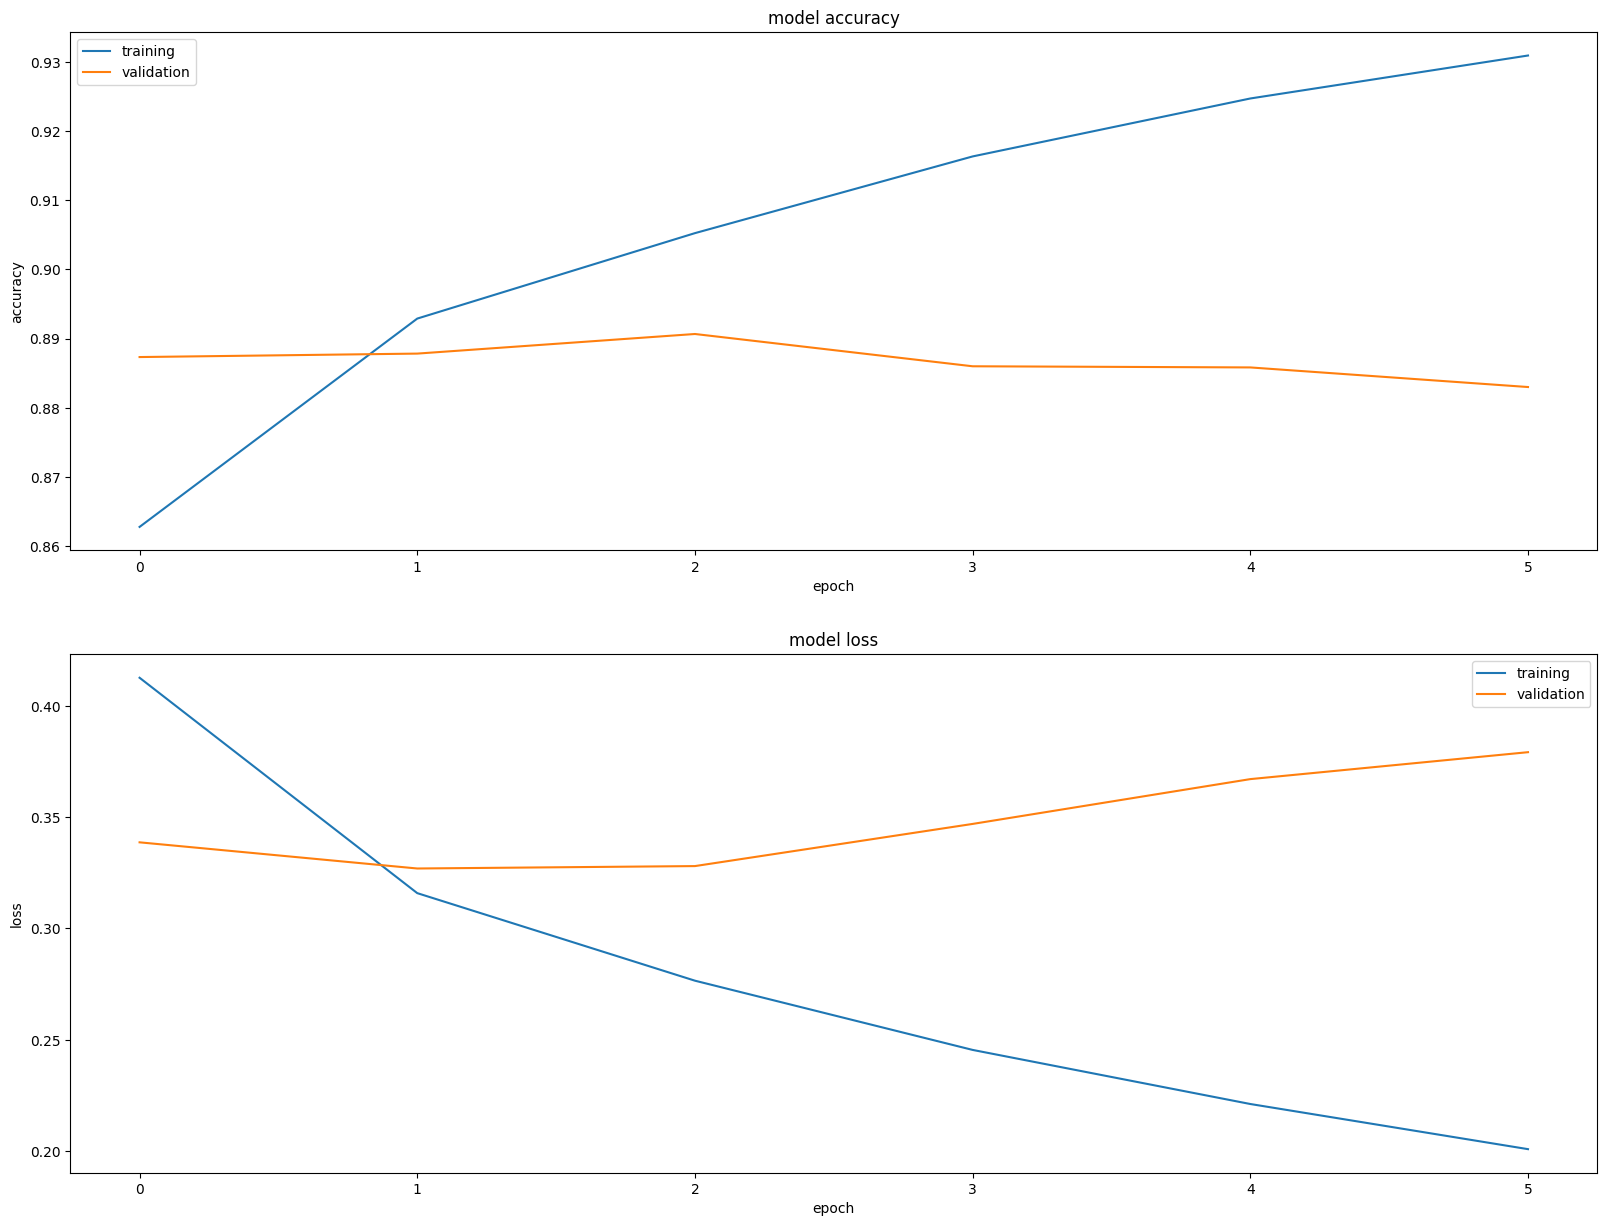

In [40]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_7.history['accuracy'], history_7.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_7.history['loss'], history_7.history['val_loss'], 'loss', 212)

238/238 [==============================] - 7s 16ms/step


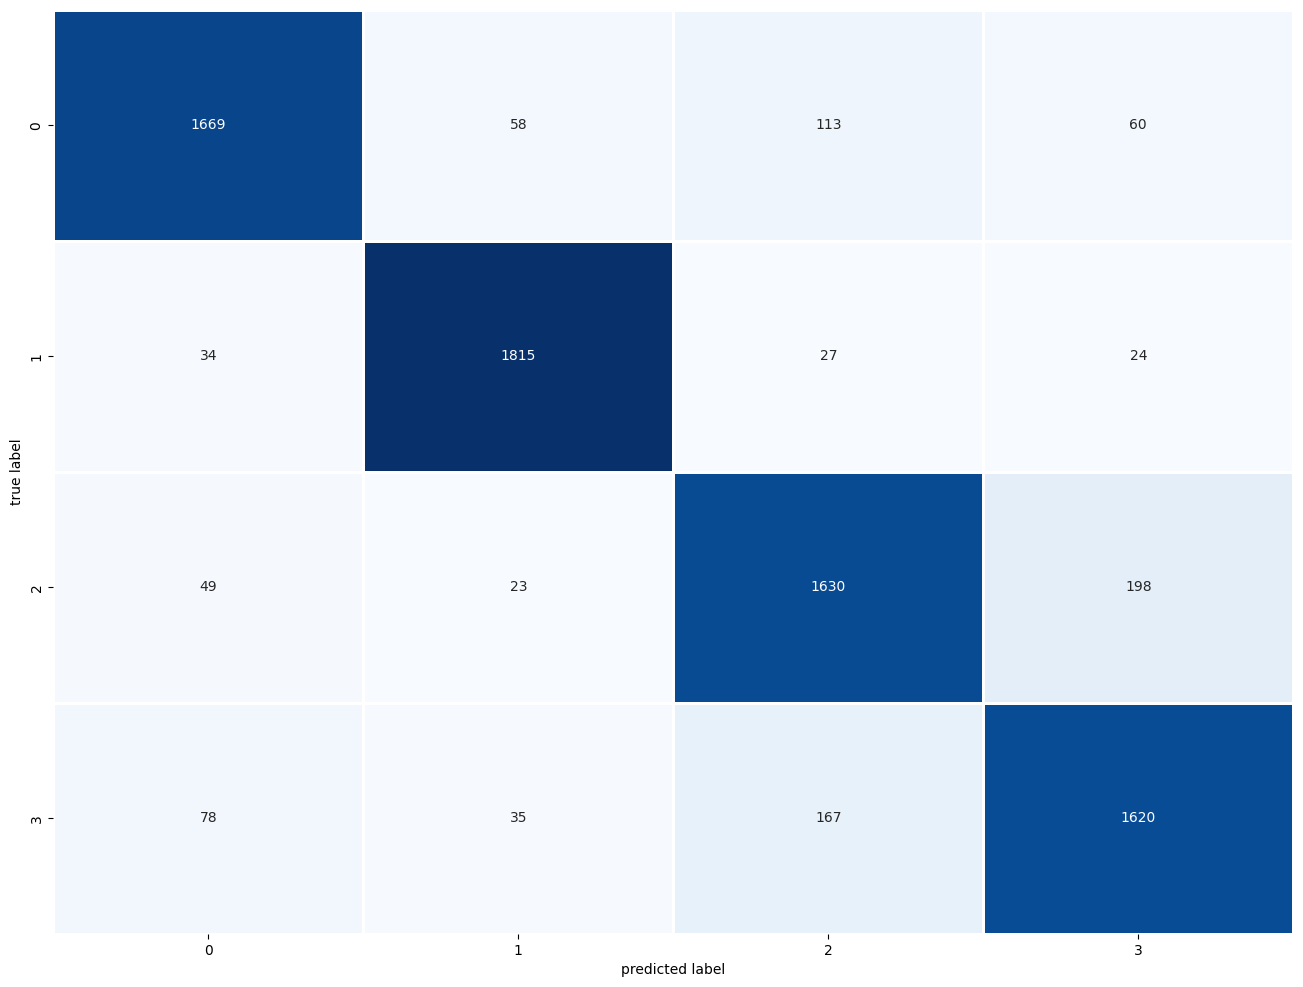

In [41]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_7.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

# LSTM 2 layer bi-directional with Dropout and L2

In [10]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(max_length,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(embedded)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.LSTM(16))(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2(0.001))(x)
outputs = layers.Dense(4, activation="softmax")(x)

model_8 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model_8.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_8.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 256)           768256    
                                                                 
 bidirectional (Bidirection  (None, 30, 64)            73984     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 32)                1056  

In [12]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [13]:
# Train the model
start_time = time.time()
history_8 = model_8.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_8 = keras.models.load_model("LSTM.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 120s 28ms/step - loss: 0.3999 - accuracy: 0.8646 - val_loss: 0.3383 - val_accuracy: 0.8835
Epoch 2/10
   1/3563 [..............................] - ETA: 1:35 - loss: 0.3748 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 83s 23ms/step - loss: 0.3049 - accuracy: 0.8957 - val_loss: 0.3230 - val_accuracy: 0.8892
Epoch 3/10
3563/3563 [==============================] - 84s 23ms/step - loss: 0.2610 - accuracy: 0.9096 - val_loss: 0.3301 - val_accuracy: 0.8920
Epoch 4/10
3563/3563 [==============================] - 83s 23ms/step - loss: 0.2257 - accuracy: 0.9220 - val_loss: 0.3564 - val_accuracy: 0.8853
Epoch 5/10
3563/3563 [==============================] - 83s 23ms/step - loss: 0.1996 - accuracy: 0.9309 - val_loss: 0.3627 - val_accuracy: 0.8917
Epoch 6/10
3563/3563 [==============================] - 85s 24ms/step - loss: 0.1773 - accuracy: 0.9383 - val_loss: 0.4096 - val_accuracy: 0.8870
Total training time: 716.51 seconds


In [14]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_8.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_8.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_8.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9134
Training Loss: 0.2506
Validation Accuracy: 0.8892
Validation Loss: 0.3230
238/238 [==============================] - 2s 8ms/step - loss: 0.3298 - accuracy: 0.8897
Test Accuracy: 0.8897
Test Loss: 0.3298


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


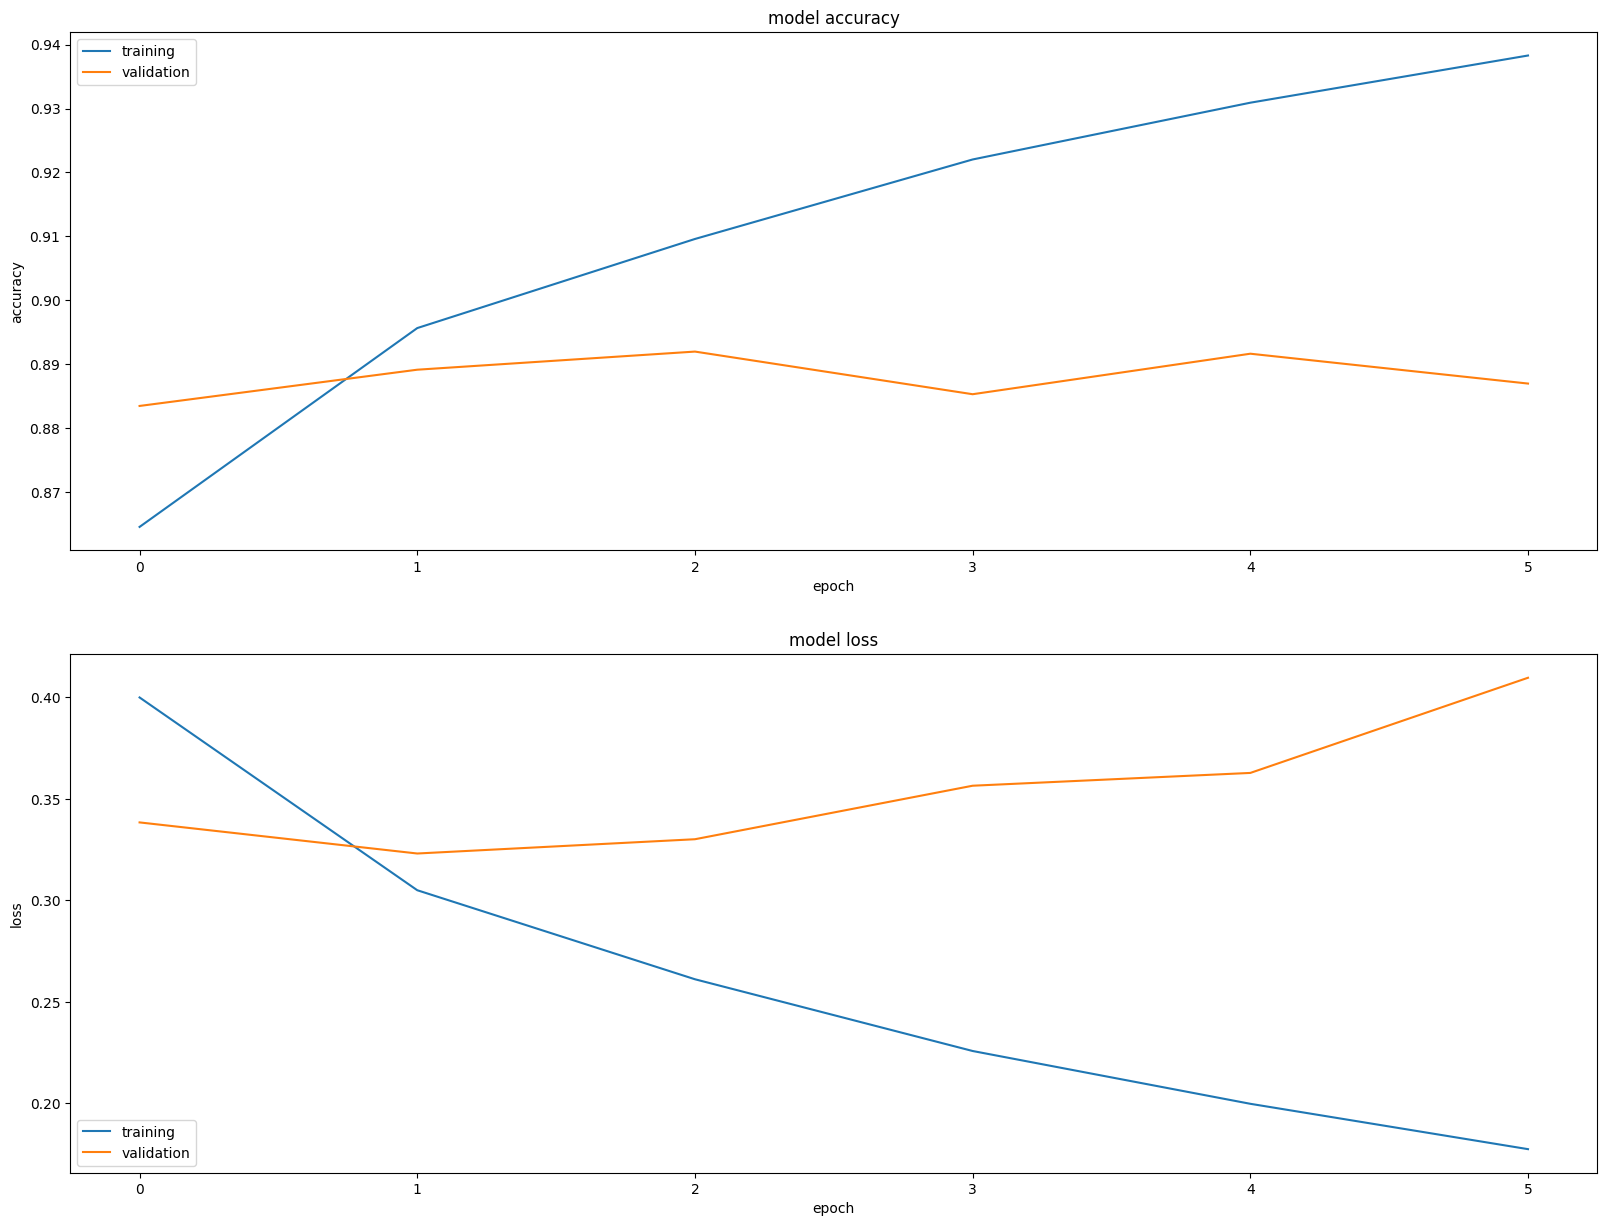

In [15]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_8.history['accuracy'], history_8.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_8.history['loss'], history_8.history['val_loss'], 'loss', 212)

238/238 [==============================] - 7s 10ms/step


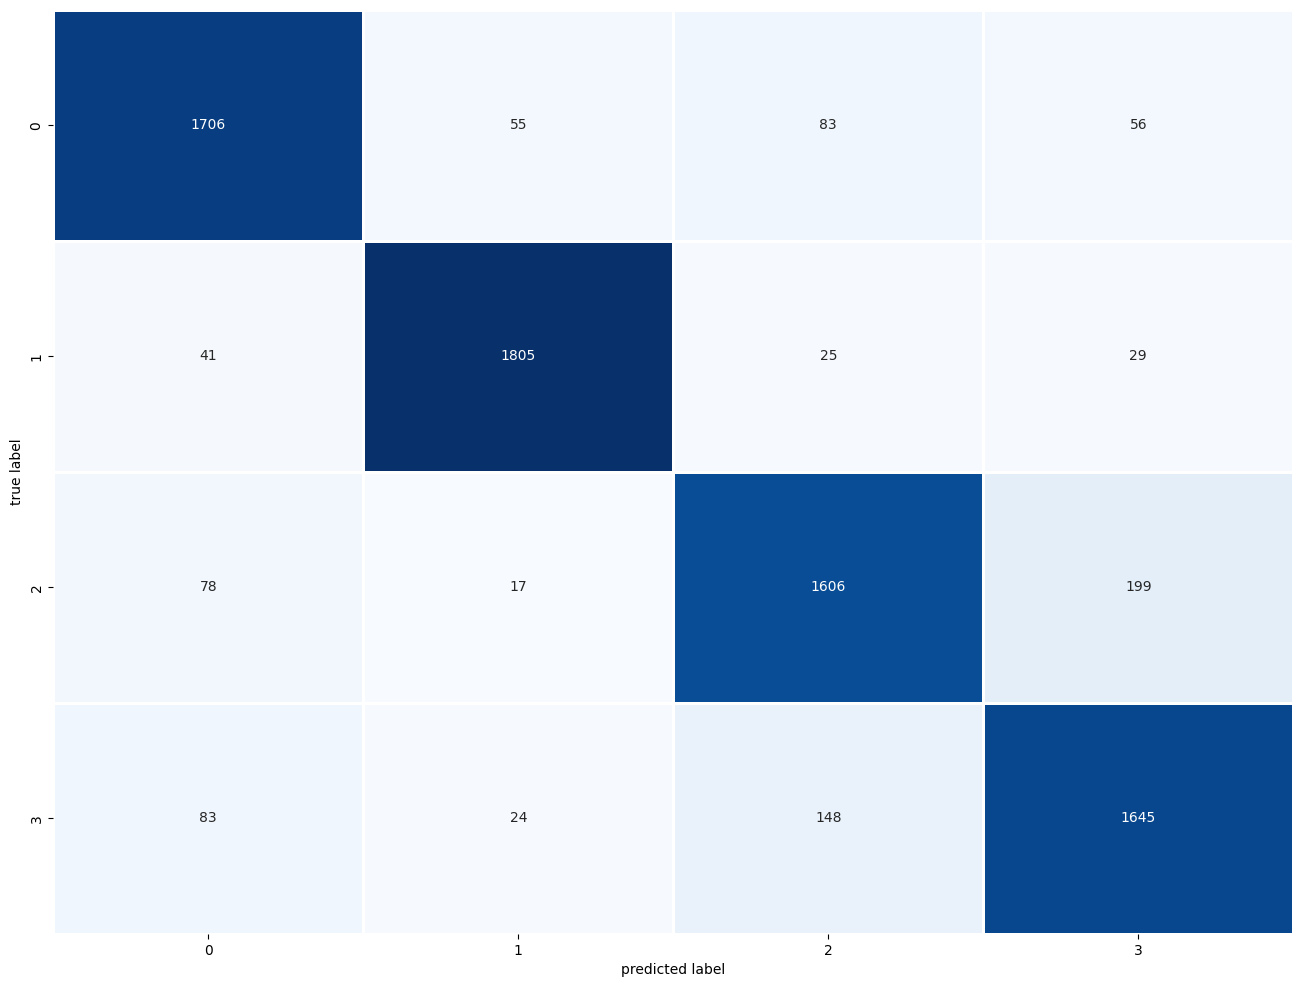

In [16]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_8.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

#1D CNN

In [19]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [20]:
model_9 = tf.keras.Model(inputs, outputs)

In [21]:
model_9.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_9.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 3001)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          288128    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                             

In [22]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [23]:
# Train the model
start_time = time.time()
history_9 = model_9.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_9 = keras.models.load_model("1Dcnn.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 29s 7ms/step - loss: 0.4387 - accuracy: 0.8445 - val_loss: 0.3945 - val_accuracy: 0.8832
Epoch 2/10
  13/3563 [..............................] - ETA: 15s - loss: 0.3521 - accuracy: 0.8966

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3563/3563 [==============================] - 19s 5ms/step - loss: 0.3188 - accuracy: 0.8891 - val_loss: 0.3678 - val_accuracy: 0.8838
Epoch 3/10
3563/3563 [==============================] - 19s 5ms/step - loss: 0.2860 - accuracy: 0.9014 - val_loss: 0.3523 - val_accuracy: 0.8883
Epoch 4/10
3563/3563 [==============================] - 19s 5ms/step - loss: 0.2628 - accuracy: 0.9081 - val_loss: 0.3443 - val_accuracy: 0.8887
Epoch 5/10
3563/3563 [==============================] - 18s 5ms/step - loss: 0.2448 - accuracy: 0.9144 - val_loss: 0.3376 - val_accuracy: 0.8868
Epoch 6/10
3563/3563 [==============================] - 19s 5ms/step - loss: 0.2312 - accuracy: 0.9193 - val_loss: 0.3381 - val_accuracy: 0.8880
Epoch 7/10
3563/3563 [==============================] - 18s 5ms/step - loss: 0.2171 - accuracy: 0.9236 - val_loss: 0.3336 - val_accuracy: 0.8872
Total training time: 144.68 seconds


In [26]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_9.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_9.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_9.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9520
Training Loss: 0.1831
Validation Accuracy: 0.8872
Validation Loss: 0.3336
238/238 [==============================] - 1s 3ms/step - loss: 0.3349 - accuracy: 0.8871
Test Accuracy: 0.8871
Test Loss: 0.3349


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


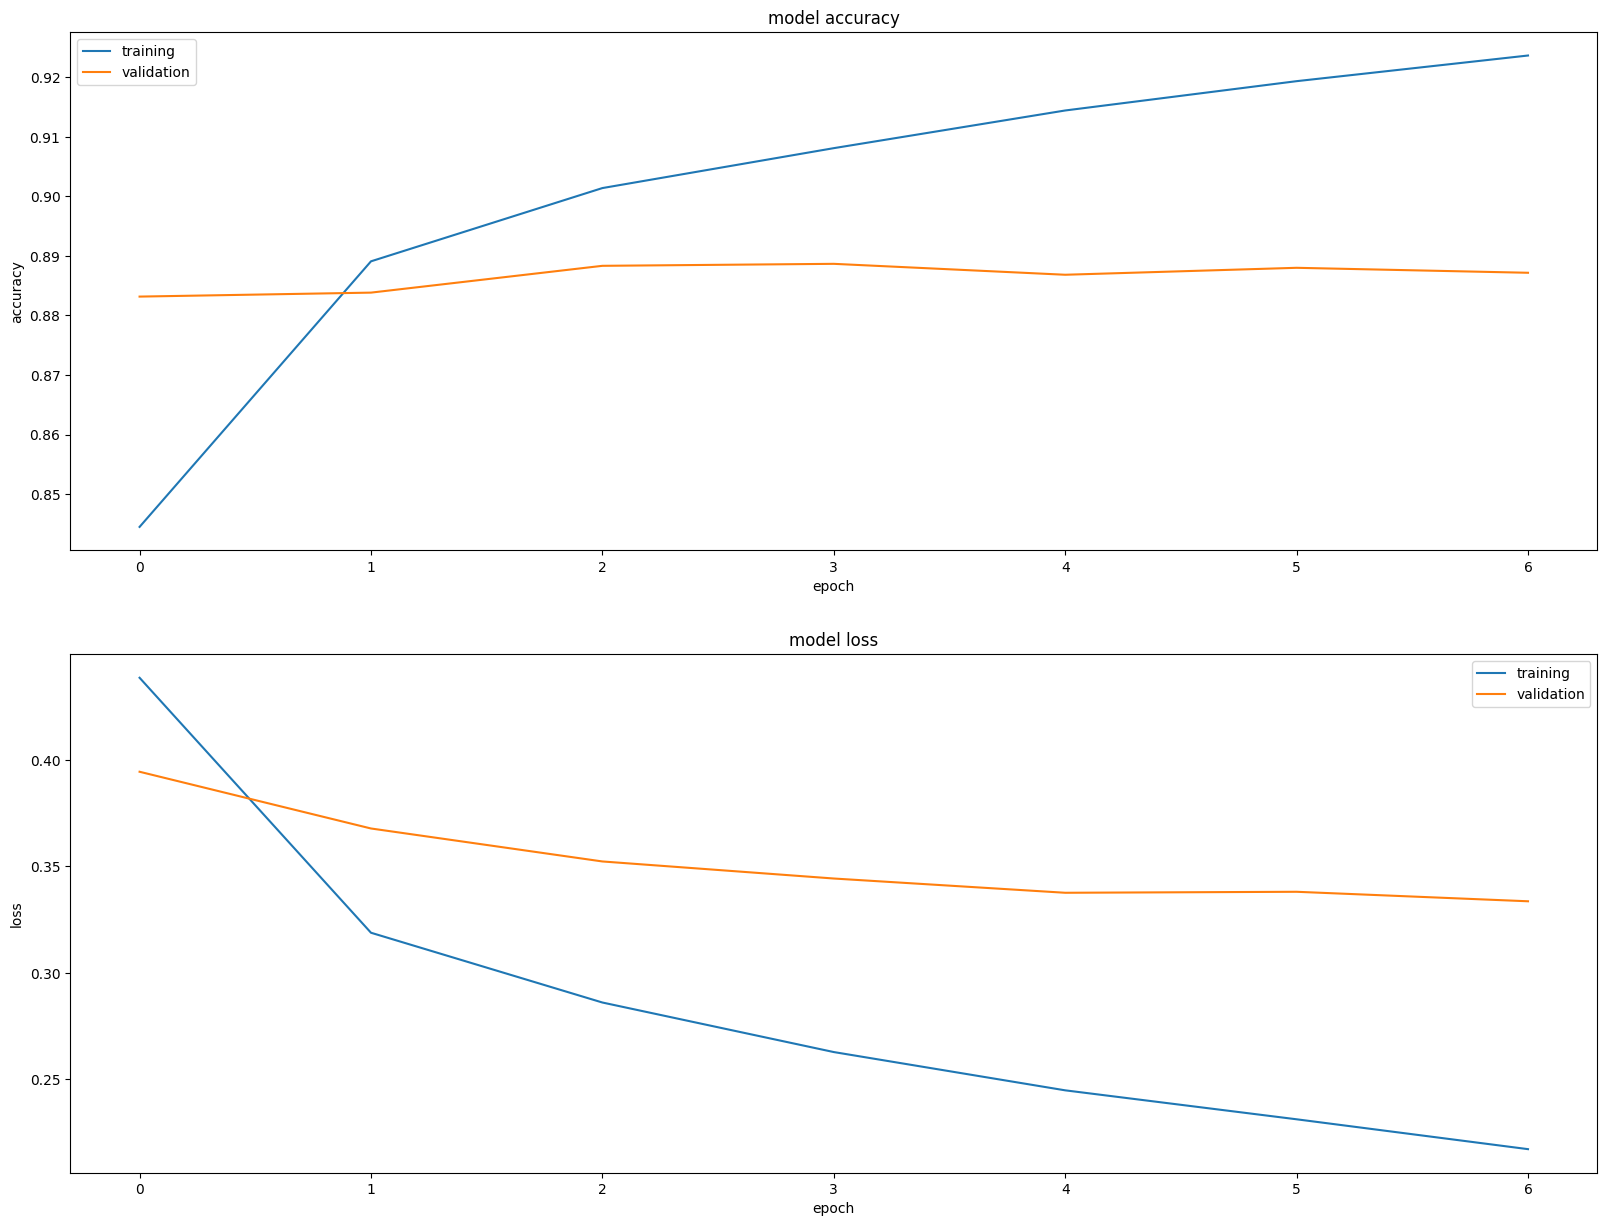

In [24]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_9.history['accuracy'], history_9.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_9.history['loss'], history_9.history['val_loss'], 'loss', 212)

238/238 [==============================] - 1s 2ms/step


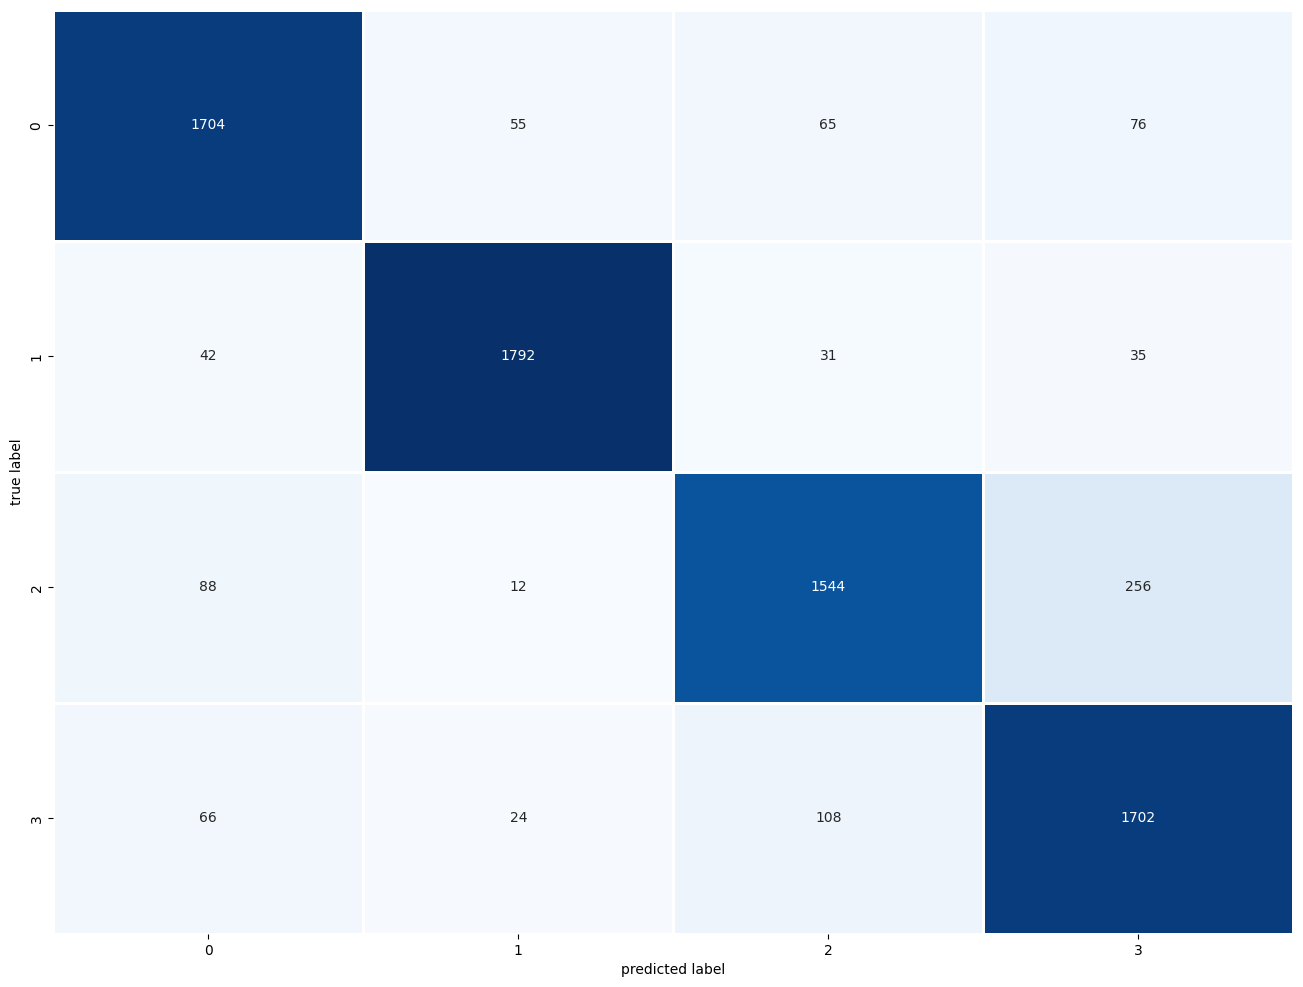

In [25]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_9.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)

#1D CNN with extra dense layer

In [8]:
k.clear_session()

max_tokens = 3000 + 1
max_length = 30

inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(embedded)
x = layers.Dropout(0.5)(x)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x)

In [9]:
model_10 = tf.keras.Model(inputs, outputs)

In [10]:
model_10.compile(optimizer="adam",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model_10.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 3001)        0         
                                                                 
 conv1d (Conv1D)             (None, None, 32)          288128    
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 32)          0         
 D)                                                              
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                             

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("1Dcnn.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]

In [13]:
# Train the model
start_time = time.time()
history_10 = model_10.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model_10 = keras.models.load_model("1Dcnn.h5")
end_time = time.time()

# Calculate the total training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

Epoch 1/10
3563/3563 [==============================] - 254s 70ms/step - loss: 0.4480 - accuracy: 0.8382 - val_loss: 0.3973 - val_accuracy: 0.8802


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
3563/3563 [==============================] - 225s 63ms/step - loss: 0.3282 - accuracy: 0.8859 - val_loss: 0.3744 - val_accuracy: 0.8852
Epoch 3/10
3563/3563 [==============================] - 222s 62ms/step - loss: 0.2928 - accuracy: 0.8988 - val_loss: 0.3374 - val_accuracy: 0.8908
Epoch 4/10
3563/3563 [==============================] - 223s 62ms/step - loss: 0.2672 - accuracy: 0.9061 - val_loss: 0.3325 - val_accuracy: 0.8910
Epoch 5/10
3563/3563 [==============================] - 223s 63ms/step - loss: 0.2493 - accuracy: 0.9134 - val_loss: 0.3247 - val_accuracy: 0.8922
Epoch 6/10
3563/3563 [==============================] - 222s 62ms/step - loss: 0.2340 - accuracy: 0.9179 - val_loss: 0.3279 - val_accuracy: 0.8850
Epoch 7/10
3563/3563 [==============================] - 223s 63ms/step - loss: 0.2216 - accuracy: 0.9218 - val_loss: 0.3216 - val_accuracy: 0.8903
Epoch 8/10
3563/3563 [==============================] - 226s 63ms/step - loss: 0.2103 - accuracy: 0.9260 - val_loss: 0

In [14]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model_10.evaluate(int_train_ds, verbose=0)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model_10.evaluate(int_val_ds, verbose=0)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

# Evaluate the model on the test dataset
loss, accuracy = model_10.evaluate(int_test_ds)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

Training Accuracy: 0.9502
Training Loss: 0.1813
Validation Accuracy: 0.8903
Validation Loss: 0.3216
238/238 [==============================] - 6s 25ms/step - loss: 0.3363 - accuracy: 0.8842
Test Accuracy: 0.8842
Test Loss: 0.3363


<ipython-input-4-273406cf14be>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


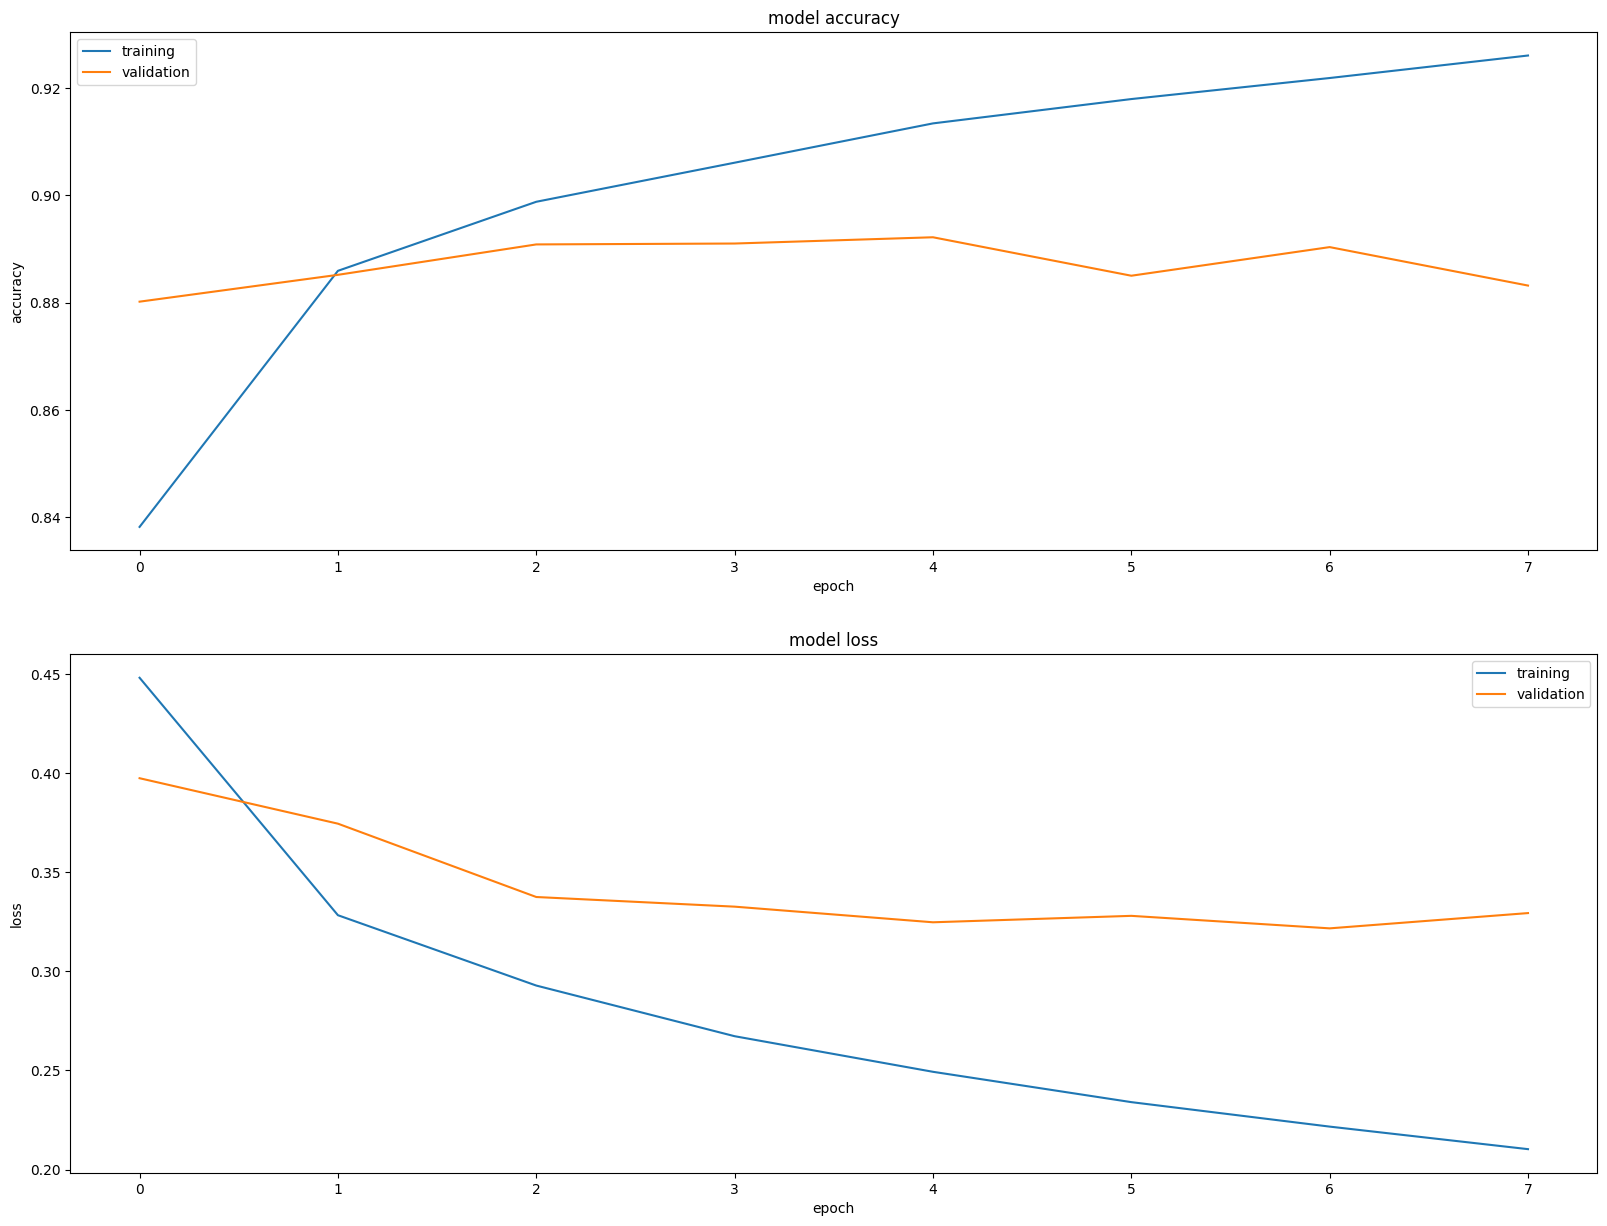

In [15]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history_10.history['accuracy'], history_10.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history_10.history['loss'], history_10.history['val_loss'], 'loss', 212)

238/238 [==============================] - 4s 16ms/step


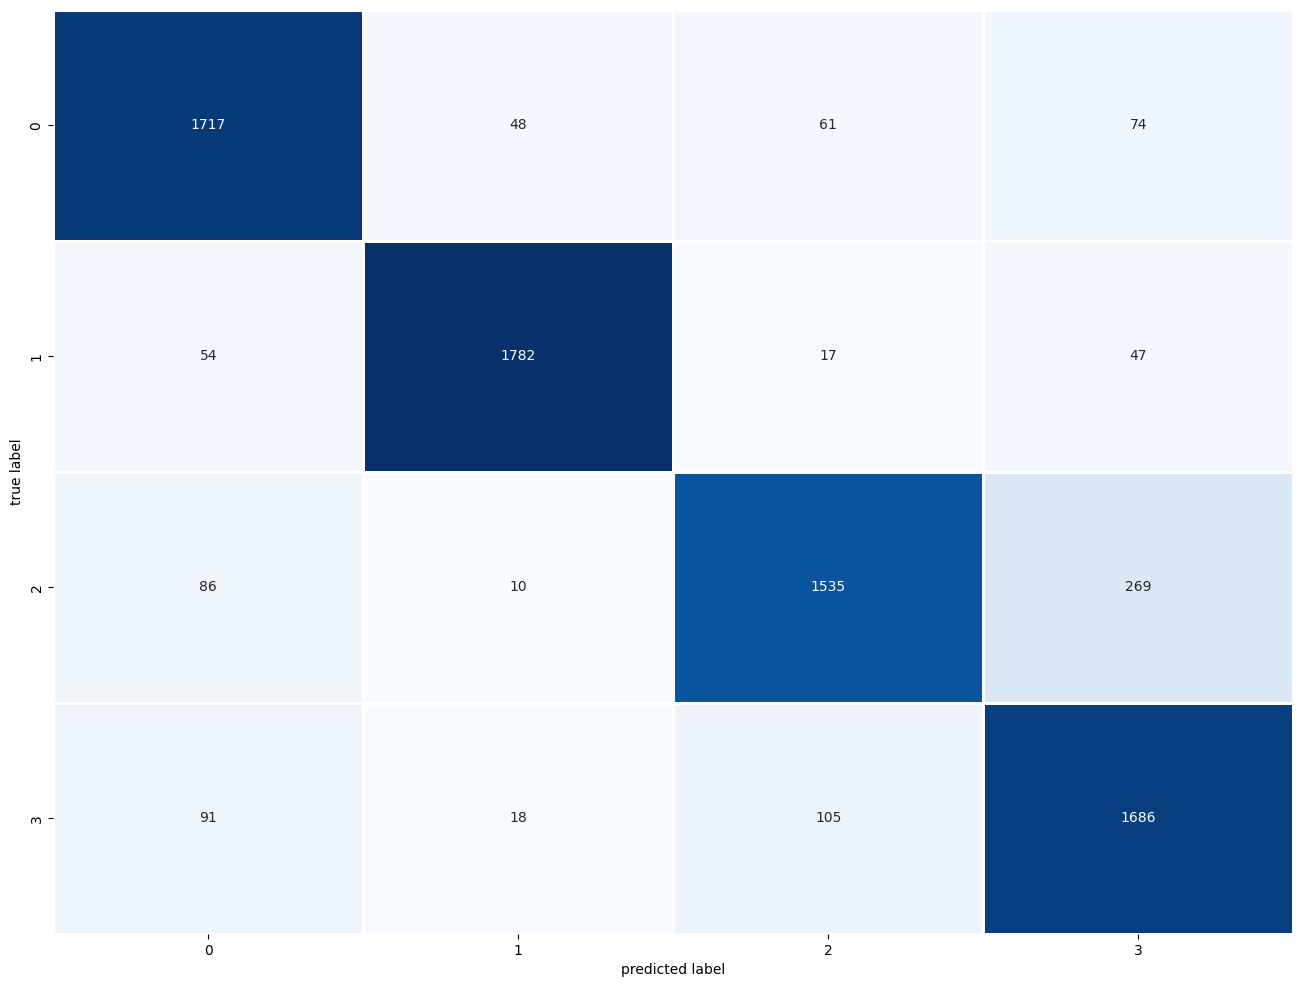

In [16]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model_10.predict(int_test_ds), axis=-1)

plot_confusion_matrix(y_test,pred_classes)